# 📊 Análisis de Reservas - esBarre

Este notebook se centra **solo en las reservas (visitas)**, partiendo del mismo fichero de Mindbody.

En este análisis vamos a:
- Cargar y preparar los datos de reservas.
- Excluir agosto (mes cerrado) para que no distorsione la serie.
- Ver la evolución de las reservas por mes y por local.
- Calcular reservas por persona (media) y su evolución.

Más adelante podremos añadir: reservas por tipo de reserva, por canal, nuevos vs recurrentes, etc.


In [14]:
# 1. Importar librerías y configurar entorno

import json
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

print("✅ Librerías cargadas")

# 2. Cargar datos de Mindbody (visitas / reservas)

RUTA_FICHERO = 'Detailed Visit Information.json'

with open(RUTA_FICHERO, 'r') as f:
    data = json.load(f)

reservas = pd.DataFrame(data)

# 3. Preparar fechas y columnas auxiliares

# Convertir columnas de fecha
reservas['Fecha de Visita'] = pd.to_datetime(reservas['Fecha de Visita'], format='mixed')
reservas['Fecha y Hora de Creacion UTC'] = pd.to_datetime(reservas['Fecha y Hora de Creacion UTC'], format='mixed')

# Columnas de año/mes
reservas['Año'] = reservas['Fecha de Visita'].dt.year
reservas['Mes'] = reservas['Fecha de Visita'].dt.month
reservas['Año-Mes'] = reservas['Fecha de Visita'].dt.to_period('M')
reservas['Mes_Nombre'] = reservas['Fecha de Visita'].dt.strftime('%Y-%m')

# Excluir diciembre 2025 si quieres ser consistente con el otro notebook
reservas = reservas[~((reservas['Año'] == 2025) & (reservas['Mes'] == 12))]

# Excluir agosto (estudio cerrado)
reservas = reservas[reservas['Mes'] != 8]

print("✅ Fechas preparadas, agosto y dic-2025 excluidos")
print(f"📅 Rango de fechas: {reservas['Fecha de Visita'].min().date()} a {reservas['Fecha de Visita'].max().date()}")

# Categorización de Pricing Options
clase_suelta = ['1 Clase', '1 Clase ']
gympass = ['Gympass']
bonos = [
    'Bono Mensual 12 Clases', 
    'Bono Mensual 8 Clases', 
    'Bono Mensual 5 Clases', 
    'Bono Mensual Ilimitado',
    'Bono 3 Clases',
    'Unpaid Bonos'
]
classpass = ['ClassPass']
invitaciones_descuentos = [
    '1 Clase Invitacion', 
    '1 Clase Invitacion ',
    'Unpaid Family&Friends - Pre-Open',
    'Clase de Cortesía',
    'CLASE PRUEBA TRAFALGAR',
    'Friends & Family',
        'DESCUENTO 50% BONO 5 TRAFALGAR',
    'DESCUENTO 50% BONO 8 TRAFALGAR'
]
villapadierna = [
    'Villapadierna ilimitado',
    'Unpaid Villa Padierna x esBarré',
    'Villa Padierna Ilimitado'
]

# Crear nueva columna tipo_reserva
def categorizar_pricing_option(pricing_option):
    if pricing_option in clase_suelta:
        return 'Clase Suelta'
    elif pricing_option in gympass:
        return 'Gympass'
    elif pricing_option in bonos:
        return 'Bonos'
    elif pricing_option in classpass:
        return 'ClassPass'
    elif pricing_option in invitaciones_descuentos:
        return 'Descuentos'
    elif pricing_option in villapadierna:
        return 'Villa Padierna'
    else:
        return 'Otros'

reservas['tipo_reserva'] = reservas['Pricing Option'].apply(categorizar_pricing_option)

reservas = reservas[reservas.tipo_reserva!='Villa Padierna']

reservas.head(3)


✅ Librerías cargadas
✅ Fechas preparadas, agosto y dic-2025 excluidos
📅 Rango de fechas: 2024-09-11 a 2025-11-30


,Categoria de Visita,Email,Esta Cancelada,Esta Perdida,Fecha de Visita,Fecha y Hora de Creacion UTC,ID de Ubicacion,ID de la Clase,ID del Cliente,ID del Estudio,ID del Grupo de Tipos,ID del Tipo de Visita,Indicador de Servicios Adicionales,Is Complimentary,Is Staff Paid,Most Recent Visit Date,Nombre de la Clase,Nombre de la Ubicacion,Nombre del Cliente,Nombre del Sitio,Numero de Referencia de la Visita,Payment Method Ids,Payment Method Names,Pmtrefno,Pricing Option,Primera Reserva,Registrado,Reserva Online,Tipo de Visita,Trainer Full Name,Trainer Id,Visit Service Category Name,Visitas Totales,Visits Remaining on Pricing Option,Reserva de Hitos,Visit Room,Año,Mes,Año-Mes,Mes_Nombre,tipo_reserva
195,CLASS,vidal.yara@gmail.com,0,0,2025-11-30,2025-11-26 22:36:18.600,2,654,100012099,5738675,23,47,Non-Add On,0,1,2025-11-30 00:00:00,esPause,Trafalgar - esBarré,Yarq Vidal,esBarre,79398,801,Apple Pay,52339,1 Clase,1,1.0,True,Barre,Adriana Ramos,100000031,Bonos,42280,0,NaN,NaN,2025,11,2025-11,2025-11,Clase Suelta
196,CLASS,alessandra.miglio@gmail.com,0,0,2025-11-30,2025-11-24 22:38:05.000,2,655,100010887,5738675,23,47,Non-Add On,0,1,2025-11-30 00:00:00,esPause,Trafalgar - esBarré,Alessandra Miglio,esBarre,78827,9,Otro,47760,DESCUENTO 50% BONO 5 TRAFALGAR,0,1.0,True,Barre,Adriana Ramos,100000031,Bonos,42280,1,NaN,NaN,2025,11,2025-11,2025-11,Descuentos
197,CLASS,iria.villamarin@gmail.com,0,0,2025-11-30,2025-11-24 16:34:53.000,2,655,100004208,5738675,23,47,Non-Add On,1,1,2025-11-30 00:00:00,esPause,Trafalgar - esBarré,Iria Eiriz,esBarre,78680,7,Cortesía/Invitado,15783,Gympass,0,1.0,False,Barre,Adriana Ramos,100000031,Bonos,42280,0,NaN,NaN,2025,11,2025-11,2025-11,Gympass


In [15]:
# 4. Resumen general rápido de reservas

print("="*60)
print("📊 RESUMEN GENERAL DE RESERVAS")
print("="*60)

print(f"Total de reservas (visitas): {len(reservas):,}")
print(f"Clientes únicos: {reservas['ID del Cliente'].nunique():,}")
print(f"Clases distintas: {reservas['ID de la Clase'].nunique():,}")
print(f"Locales: {reservas['Nombre de la Ubicacion'].nunique():,}\n")

print("🏢 Reservas por local:")
res_por_local = reservas['Nombre de la Ubicacion'].value_counts()
for loc, n in res_por_local.items():
    clientes_loc = reservas[reservas['Nombre de la Ubicacion'] == loc]['ID del Cliente'].nunique()
    print(f"  - {loc}: {n:,} reservas | {clientes_loc:,} clientes")

print("\n📅 Reservas por mes (total):")
res_por_mes = reservas.groupby('Mes_Nombre').size()
display(res_por_mes.to_frame('Reservas'))


📊 RESUMEN GENERAL DE RESERVAS
Total de reservas (visitas): 41,445
Clientes únicos: 8,832
Clases distintas: 562
Locales: 2

🏢 Reservas por local:
  - López de Hoyos - esBarre: 38,484 reservas | 7,825 clientes
  - Trafalgar - esBarré: 2,961 reservas | 1,381 clientes

📅 Reservas por mes (total):


,Reservas
Mes_Nombre,
2024-09,1362
2024-10,3229
2024-11,3098
2024-12,2248
2025-01,2960
2025-02,3156
2025-03,3529
2025-04,2741
2025-05,2921


📊 Tabla de reservas por mes y local con métricas:


Nombre de la Ubicacion,López de Hoyos - esBarre,Trafalgar - esBarré,TOTAL,MoM% López,MoM% Trafalgar,López vs Trafalgar %,YoY% López
Año-Mes,,,,,,,
2024-09,1362,0,1362,-,-,-,-
2024-10,3229,0,3229,+137.1%,-,-,-
2024-11,3098,0,3098,-4.1%,-,-,-
2024-12,2248,0,2248,-27.4%,-,-,-
2025-01,2960,0,2960,+31.7%,-,-,-
2025-02,3156,0,3156,+6.6%,-,-,-
2025-03,3529,0,3529,+11.8%,-,-,-
2025-04,2741,0,2741,-22.3%,-,-,-
2025-05,2921,0,2921,+6.6%,-,-,-


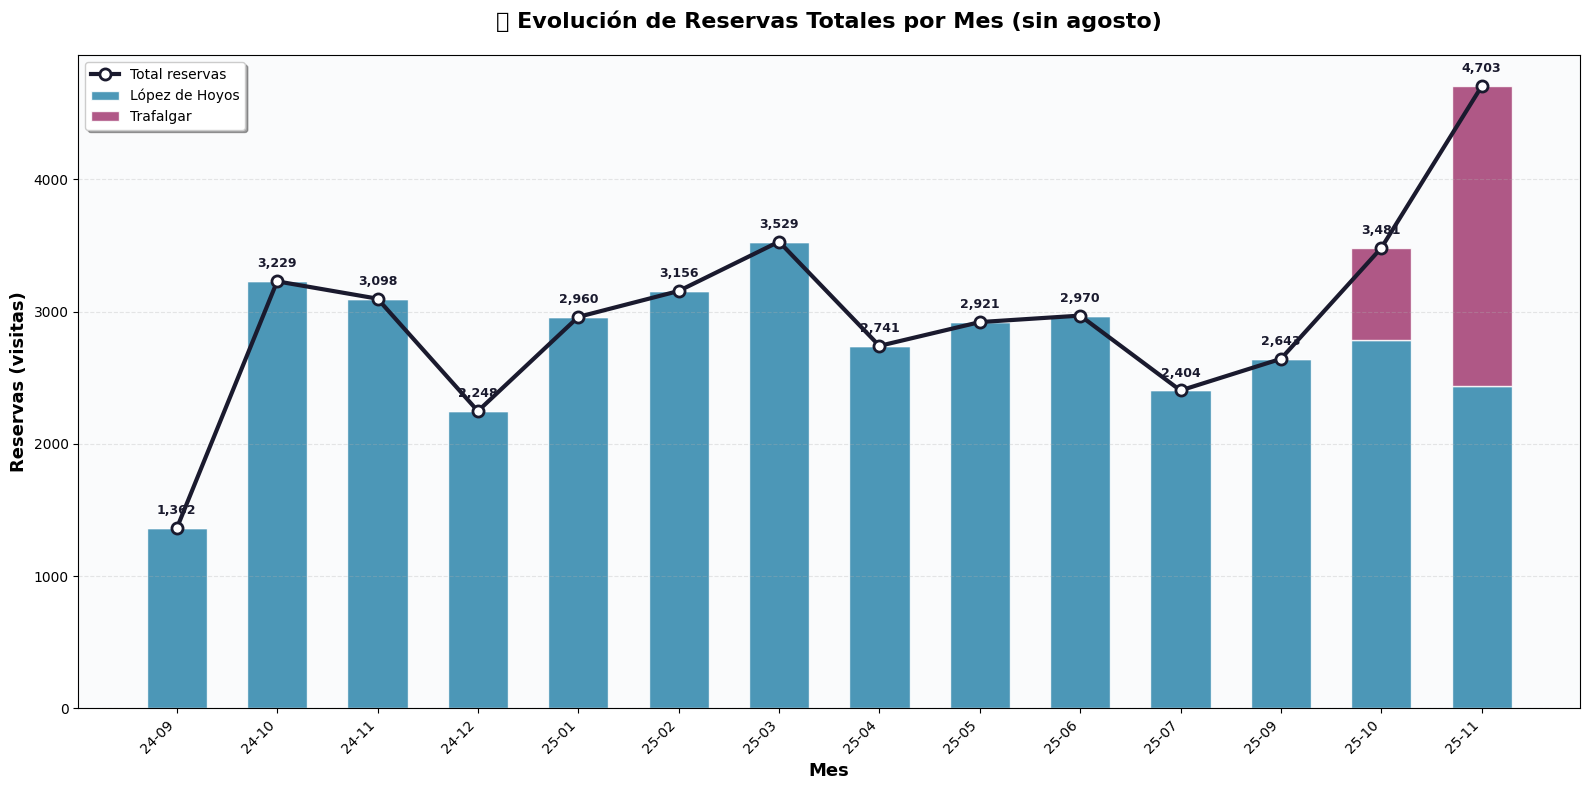

In [16]:
# 5. Evolución de reservas totales por mes y por local

# Agrupar reservas por mes y local
res_mes_loc = (
    reservas
    .groupby(['Año-Mes', 'Nombre de la Ubicacion'])
    .size()
    .reset_index(name='Reservas')
)

pivot_res_mes_loc = res_mes_loc.pivot(index='Año-Mes', columns='Nombre de la Ubicacion', values='Reservas').fillna(0)

# Orden cronológico
pivot_res_mes_loc = pivot_res_mes_loc.sort_index()

# Calcular total
pivot_res_mes_loc['TOTAL'] = pivot_res_mes_loc.sum(axis=1)

# Crear DataFrame con métricas adicionales
tabla_completa = pivot_res_mes_loc.astype(int).copy()

# Calcular MoM% para López de Hoyos
lopez_col = 'López de Hoyos - esBarre'
trafalgar_col = 'Trafalgar - esBarré'

tabla_completa['MoM% López'] = tabla_completa[lopez_col].pct_change() * 100
tabla_completa['MoM% Trafalgar'] = tabla_completa[trafalgar_col].pct_change() * 100

# Comparación entre locales (López vs Trafalgar en %)
tabla_completa['López vs Trafalgar %'] = tabla_completa.apply(
    lambda row: ((row[lopez_col] - row[trafalgar_col]) / row[trafalgar_col] * 100) if row[trafalgar_col] > 0 else None, axis=1
)

# Calcular YoY% para López de Hoyos (Sep, Oct, Nov 2025 vs 2024)
tabla_completa['YoY% López'] = None

# Crear diccionario de valores 2024 para López de Hoyos
lopez_2024 = {}
for periodo in tabla_completa.index:
    periodo_str = str(periodo)
    if periodo_str.startswith('2024'):
        mes = periodo_str[-2:]
        lopez_2024[mes] = tabla_completa.loc[periodo, lopez_col]

# Calcular YoY para meses de 2025
for periodo in tabla_completa.index:
    periodo_str = str(periodo)
    if periodo_str.startswith('2025'):
        mes = periodo_str[-2:]
        if mes in ['09', '10', '11'] and mes in lopez_2024:
            valor_2025 = tabla_completa.loc[periodo, lopez_col]
            valor_2024 = lopez_2024[mes]
            if valor_2024 > 0:
                yoy = ((valor_2025 - valor_2024) / valor_2024) * 100
                tabla_completa.loc[periodo, 'YoY% López'] = yoy

# Formatear columnas de porcentaje
def format_pct(val):
    if pd.isna(val) or val is None:
        return '-'
    return f"{val:+.1f}%"

tabla_display = tabla_completa.copy()
tabla_display['MoM% López'] = tabla_display['MoM% López'].apply(format_pct)
tabla_display['MoM% Trafalgar'] = tabla_display['MoM% Trafalgar'].apply(format_pct)
tabla_display['López vs Trafalgar %'] = tabla_display['López vs Trafalgar %'].apply(format_pct)
tabla_display['YoY% López'] = tabla_display['YoY% López'].apply(format_pct)

print("📊 Tabla de reservas por mes y local con métricas:")
display(tabla_display)

# Gráfico similar al de clientes activos
fig, ax = plt.subplots(figsize=(16, 8))

meses = [str(p) for p in pivot_res_mes_loc.index]
x = np.arange(len(meses))

color_lopez = '#2E86AB'
color_trafalgar = '#A23B72'
color_total = '#1a1a2e'

lopez_data = pivot_res_mes_loc.get('López de Hoyos - esBarre', pd.Series(0, index=pivot_res_mes_loc.index)).values
trafalgar_data = pivot_res_mes_loc.get('Trafalgar - esBarré', pd.Series(0, index=pivot_res_mes_loc.index)).values
total_data = pivot_res_mes_loc['TOTAL'].values

width = 0.6
ax.bar(x, lopez_data, width, label='López de Hoyos', color=color_lopez, alpha=0.85, edgecolor='white')
ax.bar(x, trafalgar_data, width, bottom=lopez_data, label='Trafalgar', color=color_trafalgar, alpha=0.85, edgecolor='white')

ax.plot(x, total_data, color=color_total, linewidth=3, marker='o', markersize=8,
        label='Total reservas', zorder=5, markerfacecolor='white', markeredgewidth=2)

for i, total in enumerate(total_data):
    ax.annotate(f'{int(total):,}', (x[i], total), textcoords='offset points',
                xytext=(0, 10), ha='center', fontsize=9, fontweight='bold', color=color_total)

ax.set_xlabel('Mes', fontsize=13, fontweight='bold')
ax.set_ylabel('Reservas (visitas)', fontsize=13, fontweight='bold')
ax.set_title('📊 Evolución de Reservas Totales por Mes (sin agosto)', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels([m[2:] for m in meses], rotation=45, ha='right')
ax.legend(loc='upper left', frameon=True, fancybox=True, shadow=True)
ax.grid(True, axis='y', linestyle='--', alpha=0.3)
ax.set_facecolor('#fafbfc')
fig.patch.set_facecolor('white')

plt.tight_layout()
plt.show()


📊 Evolución de reservas totales por tipo_reserva (sin agosto)

📊 Reservas totales por mes y tipo_reserva:


tipo_reserva,Bonos,Clase Suelta,ClassPass,Descuentos,Gympass
Año-Mes,,,,,
2024-09,244,146,548,110,314
2024-10,869,177,1291,12,880
2024-11,962,156,1120,3,857
2024-12,774,99,710,2,663
2025-01,1035,155,789,8,973
2025-02,1181,126,861,4,984
2025-03,1386,166,804,1,1172
2025-04,1100,118,632,4,887
2025-05,1124,106,667,2,1022


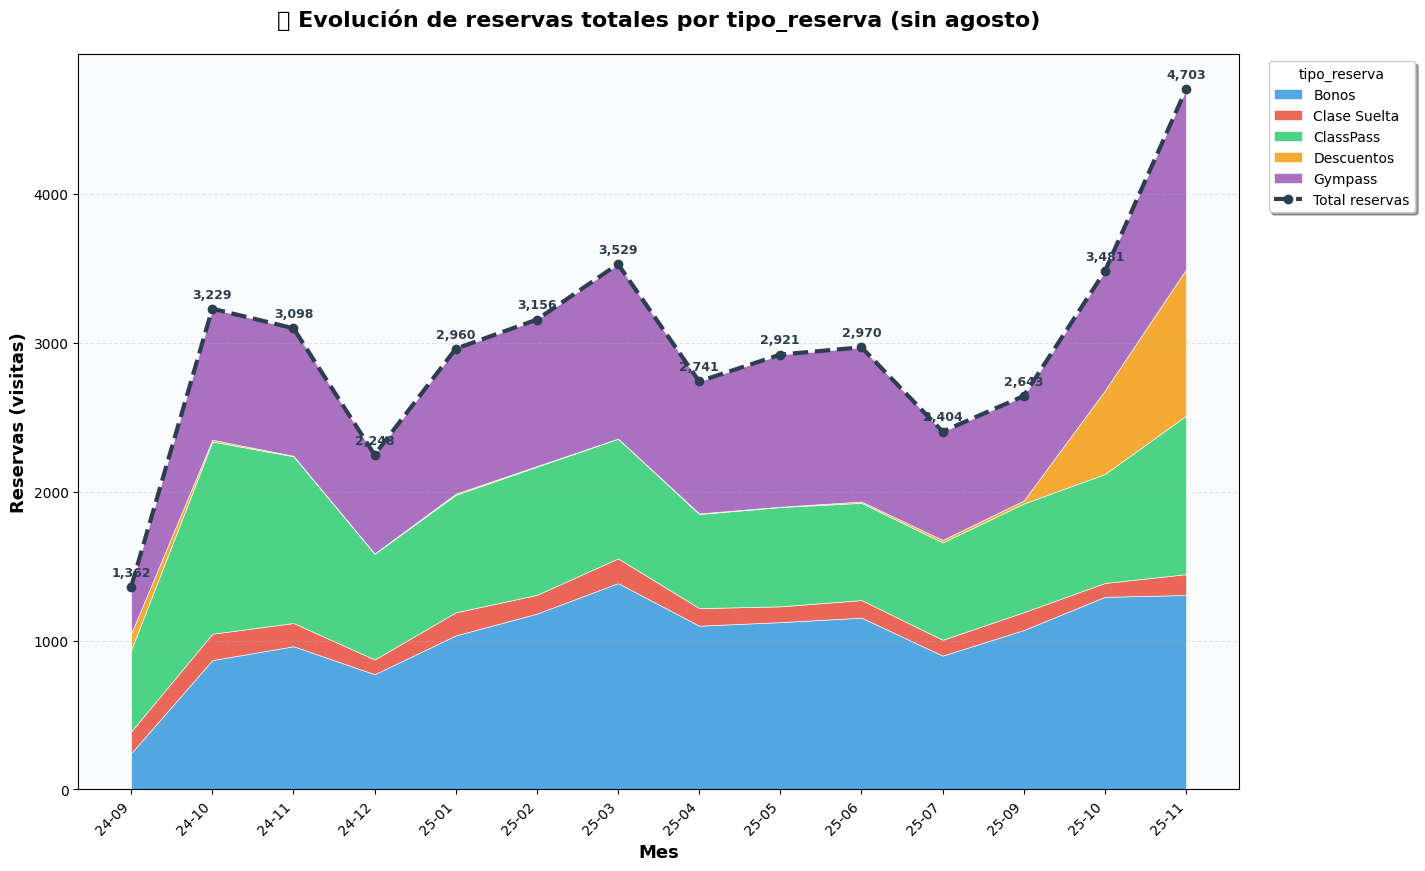


📊 Distribución porcentual mensual de reservas por tipo_reserva y local:


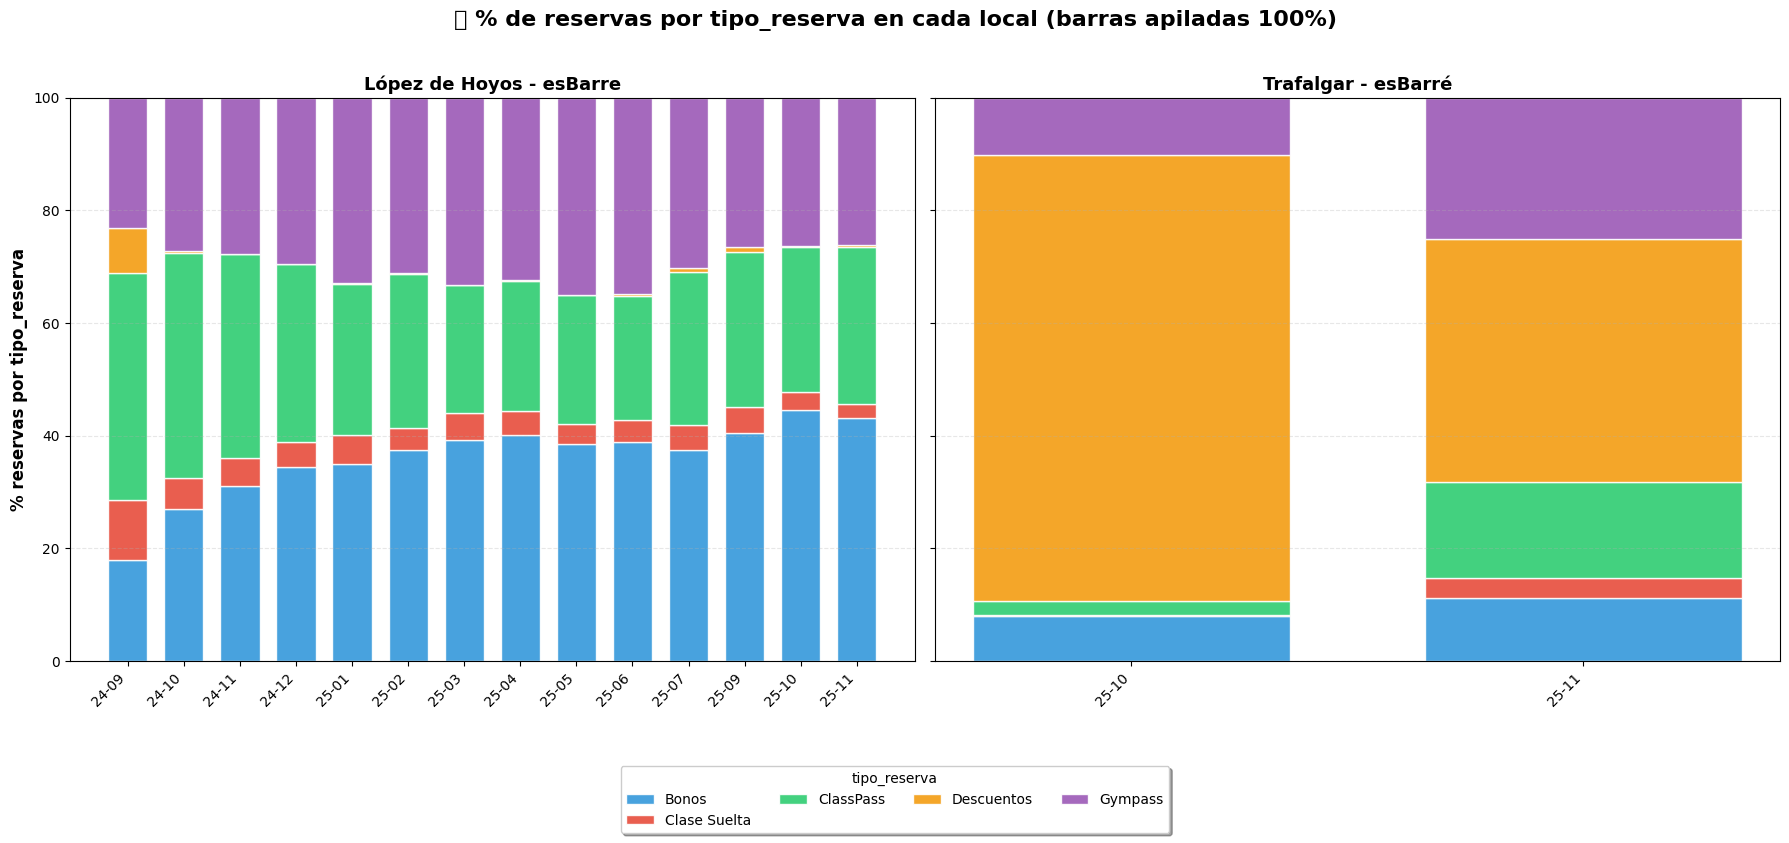

In [40]:
# 5.1 Evolución de reservas totales por tipo_reserva (sin agosto)

print("="*60)
print("📊 Evolución de reservas totales por tipo_reserva (sin agosto)")
print("="*60)

# Agrupar reservas por mes y tipo_reserva
reservas_tipo_mes = (
    reservas
    .groupby(['Año-Mes', 'tipo_reserva'])
    .size()
    .reset_index(name='Reservas')
)

pivot_reservas_tipo = (
    reservas_tipo_mes
    .pivot(index='Año-Mes', columns='tipo_reserva', values='Reservas')
    .fillna(0)
    .astype(int)
    .sort_index()
)

print("\n📊 Reservas totales por mes y tipo_reserva:")

display(pivot_reservas_tipo)

# Gráfico: stack de reservas por tipo_reserva + línea de total
fig, ax = plt.subplots(figsize=(18, 9))

meses_idx = pivot_reservas_tipo.index
meses_str = [str(p) for p in meses_idx]
x = np.arange(len(meses_str))

colores_area = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6',
                '#1abc9c', '#e67e22', '#34495e']

cols = list(pivot_reservas_tipo.columns)

ax.stackplot(
    x,
    [pivot_reservas_tipo[col].values for col in cols],
    labels=cols,
    colors=colores_area[:len(cols)],
    alpha=0.85,
    edgecolor='white',
    linewidth=0.5
)

# Línea de total
total_reservas = pivot_reservas_tipo.sum(axis=1).values
ax.plot(
    x,
    total_reservas,
    color='#2c3e50',
    linewidth=3,
    linestyle='--',
    marker='o',
    markersize=6,
    label='Total reservas',
    zorder=5
)

for i, total in enumerate(total_reservas):
    ax.annotate(
        f"{int(total):,}",
        (x[i], total),
        textcoords='offset points',
        xytext=(0, 8),
        ha='center',
        fontsize=9,
        fontweight='bold',
        color='#2c3e50'
    )

ax.set_xlabel('Mes', fontsize=13, fontweight='bold')
ax.set_ylabel('Reservas (visitas)', fontsize=13, fontweight='bold')
ax.set_title('📊 Evolución de reservas totales por tipo_reserva (sin agosto)',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels([m[2:] for m in meses_str], rotation=45, ha='right')
ax.legend(
    loc='upper left',
    bbox_to_anchor=(1.02, 1),
    frameon=True,
    fancybox=True,
    shadow=True,
    title='tipo_reserva'
)
ax.grid(True, axis='y', linestyle='--', alpha=0.3)
ax.set_facecolor('#fafbfc')
fig.patch.set_facecolor('white')

plt.tight_layout(rect=[0, 0.02, 0.8, 1])
plt.show()

# -----------------------------------------------------------------------------
# Gráfico adicional: barras apiladas 100% por tipo_reserva y por local
# -----------------------------------------------------------------------------

print("\n📊 Distribución porcentual mensual de reservas por tipo_reserva y local:")

# Agrupar por mes, local y tipo_reserva
res_tipo_loc = (
    reservas
    .groupby(['Año-Mes', 'Nombre de la Ubicacion', 'tipo_reserva'])
    .size()
    .reset_index(name='Reservas')
)

locales = sorted(res_tipo_loc['Nombre de la Ubicacion'].unique())

fig, axes = plt.subplots(1, len(locales), figsize=(18, 7), sharey=True)

# Asegurar que axes es iterable aunque solo haya un local
if len(locales) == 1:
    axes = [axes]

for ax_loc, loc in zip(axes, locales):
    df_loc = res_tipo_loc[res_tipo_loc['Nombre de la Ubicacion'] == loc]
    pivot_loc = (
        df_loc
        .pivot(index='Año-Mes', columns='tipo_reserva', values='Reservas')
        .fillna(0)
        .sort_index()
    )

    # Calcular porcentajes fila a fila
    totales_loc = pivot_loc.sum(axis=1)
    pct_loc = pivot_loc.div(totales_loc.replace(0, np.nan), axis=0) * 100

    meses_idx_loc = pct_loc.index
    meses_str_loc = [str(p) for p in meses_idx_loc]
    x_loc = np.arange(len(meses_str_loc))

    bottom = np.zeros(len(meses_str_loc))
    cols_loc = list(pct_loc.columns)

    for i, col in enumerate(cols_loc):
        valores = pct_loc[col].fillna(0).values
        ax_loc.bar(
            x_loc,
            valores,
            bottom=bottom,
            color=colores_area[i % len(colores_area)],
            edgecolor='white',
            width=0.7,
            label=str(col) if loc == locales[0] else None,
            alpha=0.9
        )
        bottom += valores

    ax_loc.set_title(loc, fontsize=13, fontweight='bold')
    ax_loc.set_xticks(x_loc)
    ax_loc.set_xticklabels([m[2:] for m in meses_str_loc], rotation=45, ha='right')
    ax_loc.set_ylim(0, 100)
    ax_loc.grid(True, axis='y', linestyle='--', alpha=0.3)
    if ax_loc is axes[0]:
        ax_loc.set_ylabel('% reservas por tipo_reserva', fontsize=12, fontweight='bold')

# Leyenda común
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.05),
    ncol=min(len(labels), 4),
    frameon=True,
    fancybox=True,
    shadow=True,
    title='tipo_reserva'
)

fig.suptitle('📊 % de reservas por tipo_reserva en cada local (barras apiladas 100%)',
             fontsize=16, fontweight='bold', y=1.02)

fig.patch.set_facecolor('white')
plt.tight_layout()
plt.show()


🔎 Causas de la bajada de reservas - Foco en López de Hoyos
Reservas en López de Hoyos - esBarre: 38,484 (7,825 clientes únicos)

📈 Nuevos clientes generados por mes en López de Hoyos (primera reserva en esBarre):


,Nuevos_Clientes_Lopez
Mes_Primera,
2024-09,937
2024-10,1167
2024-11,786
2024-12,401
2025-01,600
2025-02,550
2025-03,565
2025-04,372
2025-05,370


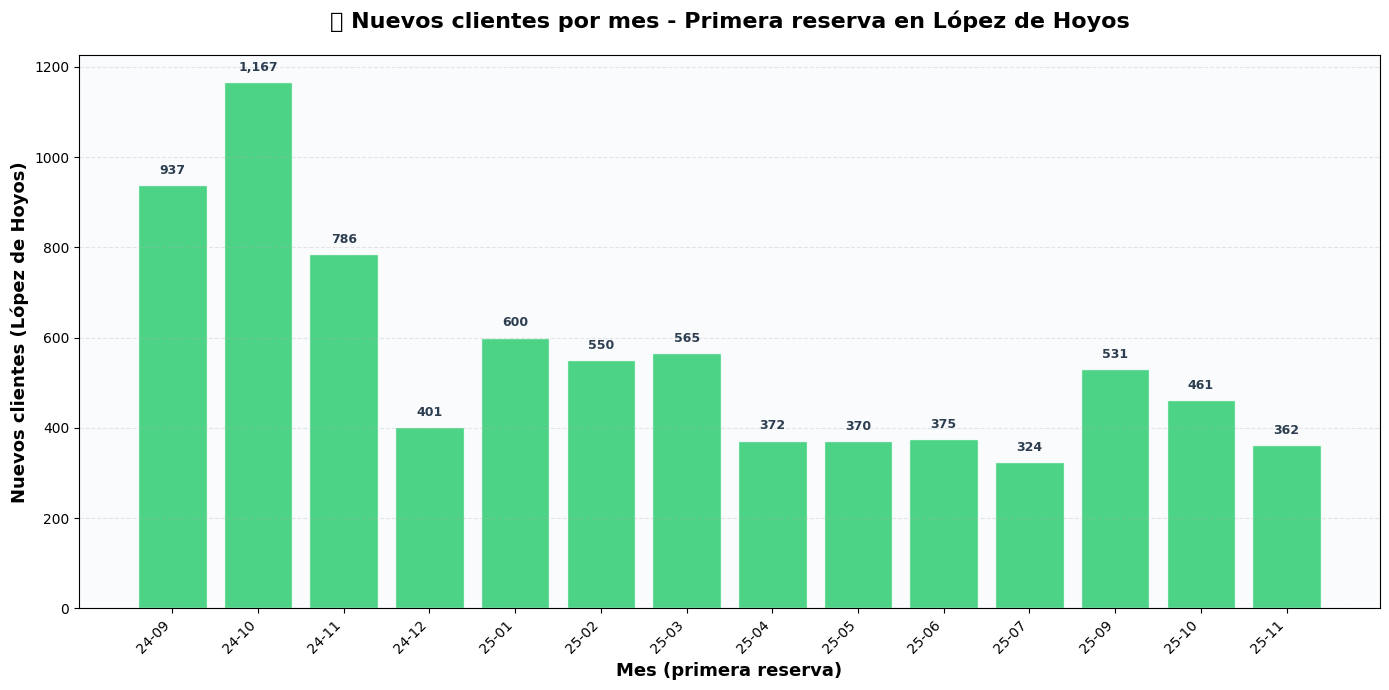


📊 Reservas por cliente activo en López de Hoyos (media mensual y acumulada):


,Reservas_Total_Lopez,Clientes_Activos_Lopez,Reservas_por_Cliente,Media_Acumulada
Año-Mes,,,,
2024-09,1362,937,1.5,1.5
2024-10,3229,1557,2.1,1.8
2024-11,3098,1377,2.2,1.9
2024-12,2248,982,2.3,2.0
2025-01,2960,1219,2.4,2.1
2025-02,3156,1264,2.5,2.2
2025-03,3529,1292,2.7,2.2
2025-04,2741,1056,2.6,2.3
2025-05,2921,1100,2.7,2.3


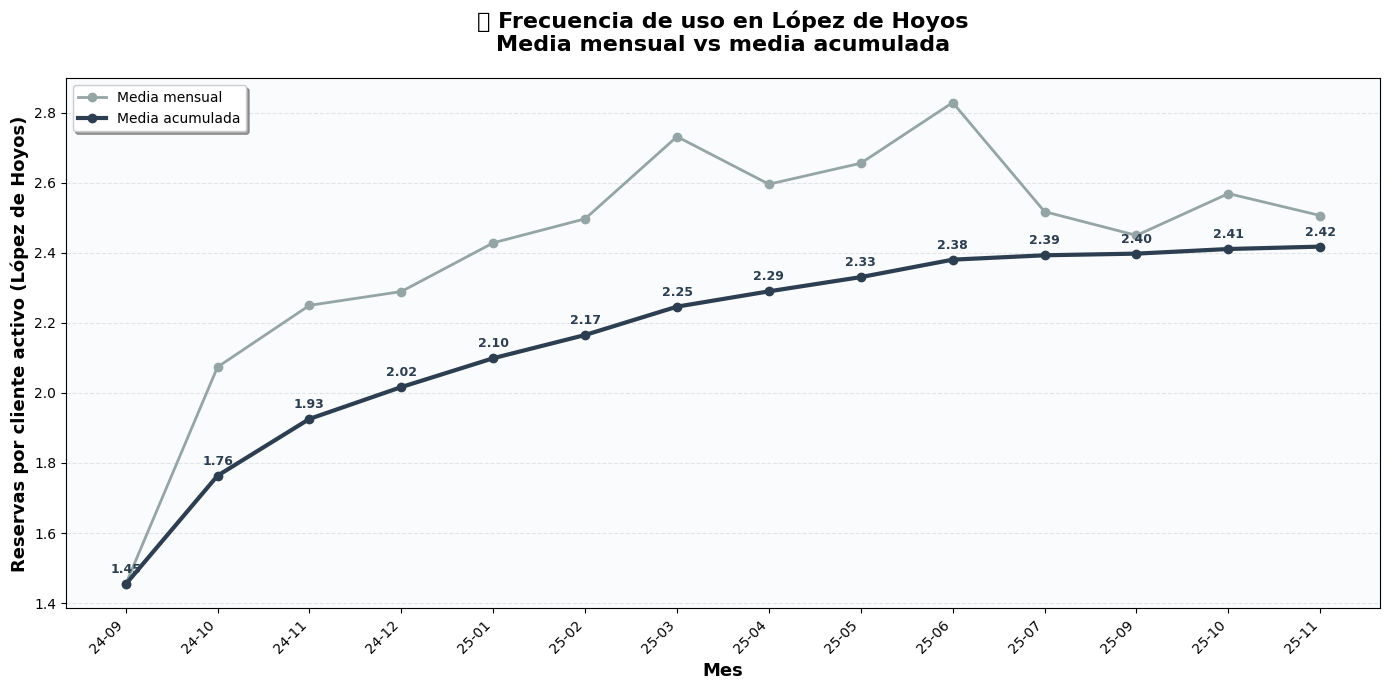

In [27]:
# 6.1 Nuevos clientes y frecuencia de uso en López de Hoyos
# Configurar formato de números para mostrar máximo un decimal
pd.options.display.float_format = '{:.1f}'.format

import numpy as np
import matplotlib.pyplot as plt

LOPEZ = 'López de Hoyos - esBarre'

print("="*70)
print("🔎 Causas de la bajada de reservas - Foco en López de Hoyos")
print("="*70)

# Subconjunto solo López de Hoyos
reservas_lopez = reservas[reservas['Nombre de la Ubicacion'] == LOPEZ].copy()

print(f"Reservas en {LOPEZ}: {len(reservas_lopez):,} (" 
      f"{reservas_lopez['ID del Cliente'].nunique():,} clientes únicos)\n")

# -----------------------------------------------------------------------------
# 6.1.1 Nuevos clientes generados por mes (primera reserva histórica empezando en López)
# -----------------------------------------------------------------------------

# Tabla de primera y última reserva por cliente (a nivel global esBarre)
clientes_ordenados = reservas.sort_values('Fecha de Visita')

primera = (
    clientes_ordenados
    .groupby('ID del Cliente')
    .head(1)
    [['ID del Cliente', 'Fecha de Visita', 'Nombre de la Ubicacion']]
    .rename(columns={'Fecha de Visita': 'Primera_Reserva',
                     'Nombre de la Ubicacion': 'Ubicacion_Primera'})
)

ultima = (
    clientes_ordenados
    .groupby('ID del Cliente')
    .tail(1)
    [['ID del Cliente', 'Fecha de Visita', 'Nombre de la Ubicacion']]
    .rename(columns={'Fecha de Visita': 'Ultima_Reserva',
                     'Nombre de la Ubicacion': 'Ubicacion_Ultima'})
)

clientes_resumen = (
    primera
    .merge(ultima, on='ID del Cliente', how='left')
    .assign(
        Mes_Primera=lambda df_: df_['Primera_Reserva'].dt.to_period('M'),
        Mes_Ultima=lambda df_: df_['Ultima_Reserva'].dt.to_period('M')
    )
)

# Nuevos clientes de esBarre cuya primera reserva fue en López de Hoyos
nuevos_lopez = clientes_resumen[clientes_resumen['Ubicacion_Primera'] == LOPEZ].copy()

nuevos_por_mes = (
    nuevos_lopez
    .groupby('Mes_Primera')['ID del Cliente']
    .nunique()
    .sort_index()
    .rename('Nuevos_Clientes_Lopez')
)

print("📈 Nuevos clientes generados por mes en López de Hoyos (primera reserva en esBarre):")

display(nuevos_por_mes.to_frame())

fig, ax = plt.subplots(figsize=(14, 7))

meses_nuevos = [str(p) for p in nuevos_por_mes.index]
x = np.arange(len(meses_nuevos))

ax.bar(x, nuevos_por_mes.values, color='#2ecc71', alpha=0.85, edgecolor='white')

for i, val in enumerate(nuevos_por_mes.values):
    ax.annotate(f"{int(val):,}", (x[i], val), textcoords='offset points',
                xytext=(0, 8), ha='center', fontsize=9, fontweight='bold', color='#2c3e50')

ax.set_xlabel('Mes (primera reserva)', fontsize=13, fontweight='bold')
ax.set_ylabel('Nuevos clientes (López de Hoyos)', fontsize=13, fontweight='bold')
ax.set_title('📈 Nuevos clientes por mes - Primera reserva en López de Hoyos',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels([m[2:] for m in meses_nuevos], rotation=45, ha='right')
ax.grid(True, axis='y', linestyle='--', alpha=0.3)
ax.set_facecolor('#fafbfc')
fig.patch.set_facecolor('white')

plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 6.1.2 Frecuencia de uso: reservas por cliente activo en López de Hoyos
# -----------------------------------------------------------------------------

reservas_lopez_mes = reservas_lopez.groupby('Año-Mes').size()
clientes_lopez_mes = reservas_lopez.groupby('Año-Mes')['ID del Cliente'].nunique()

reservas_por_cliente_lopez = (reservas_lopez_mes / clientes_lopez_mes).rename('Reservas_por_Cliente')
reservas_por_cliente_lopez = reservas_por_cliente_lopez.sort_index()

# Media acumulada (cada mes = media de ese mes y todos los anteriores)
media_acumulada_lopez = reservas_por_cliente_lopez.expanding().mean().rename('Media_Acumulada')

print("\n📊 Reservas por cliente activo en López de Hoyos (media mensual y acumulada):")

tabla_freq = pd.concat([
    reservas_lopez_mes.rename('Reservas_Total_Lopez'),
    clientes_lopez_mes.rename('Clientes_Activos_Lopez'),
    reservas_por_cliente_lopez,
    media_acumulada_lopez
], axis=1)

display(tabla_freq)

fig, ax = plt.subplots(figsize=(14, 7))

meses_freq = [str(p) for p in reservas_por_cliente_lopez.index]

# Línea de media mensual
ax.plot(meses_freq, reservas_por_cliente_lopez.values,
        marker='o', linewidth=2, color='#95a5a6', label='Media mensual')

# Línea de media acumulada
ax.plot(meses_freq, media_acumulada_lopez.values,
        marker='o', linewidth=3, color='#2c3e50', label='Media acumulada')

for x_tick, val in zip(meses_freq, media_acumulada_lopez.values):
    ax.annotate(f"{val:.2f}", (x_tick, val), textcoords='offset points',
                xytext=(0, 8), ha='center', fontsize=9, fontweight='bold', color='#2c3e50')

ax.set_xlabel('Mes', fontsize=13, fontweight='bold')
ax.set_ylabel('Reservas por cliente activo (López de Hoyos)', fontsize=13, fontweight='bold')
ax.set_title('📈 Frecuencia de uso en López de Hoyos\nMedia mensual vs media acumulada',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(meses_freq)
ax.set_xticklabels([m[2:] for m in meses_freq], rotation=45, ha='right')
ax.legend(loc='upper left', frameon=True, fancybox=True, shadow=True)
ax.grid(True, axis='y', linestyle='--', alpha=0.3)
ax.set_facecolor('#fafbfc')
fig.patch.set_facecolor('white')

plt.tight_layout()
plt.show()


📉 Churn en López de Hoyos (nuevos vs antiguos)

📉 churn_rate_new_customers (López de Hoyos):


,Mes,Nuevos_Clientes,Churn_New,churn_rate_new_customers
Mes_Primera,,,,
2024-09,2024-09,937,436,0.47
2024-10,2024-10,1167,694,0.59
2024-11,2024-11,786,485,0.62
2024-12,2024-12,401,249,0.62
2025-01,2025-01,600,357,0.59
2025-02,2025-02,550,346,0.63
2025-03,2025-03,565,364,0.64
2025-04,2025-04,372,252,0.68
2025-05,2025-05,370,236,0.64


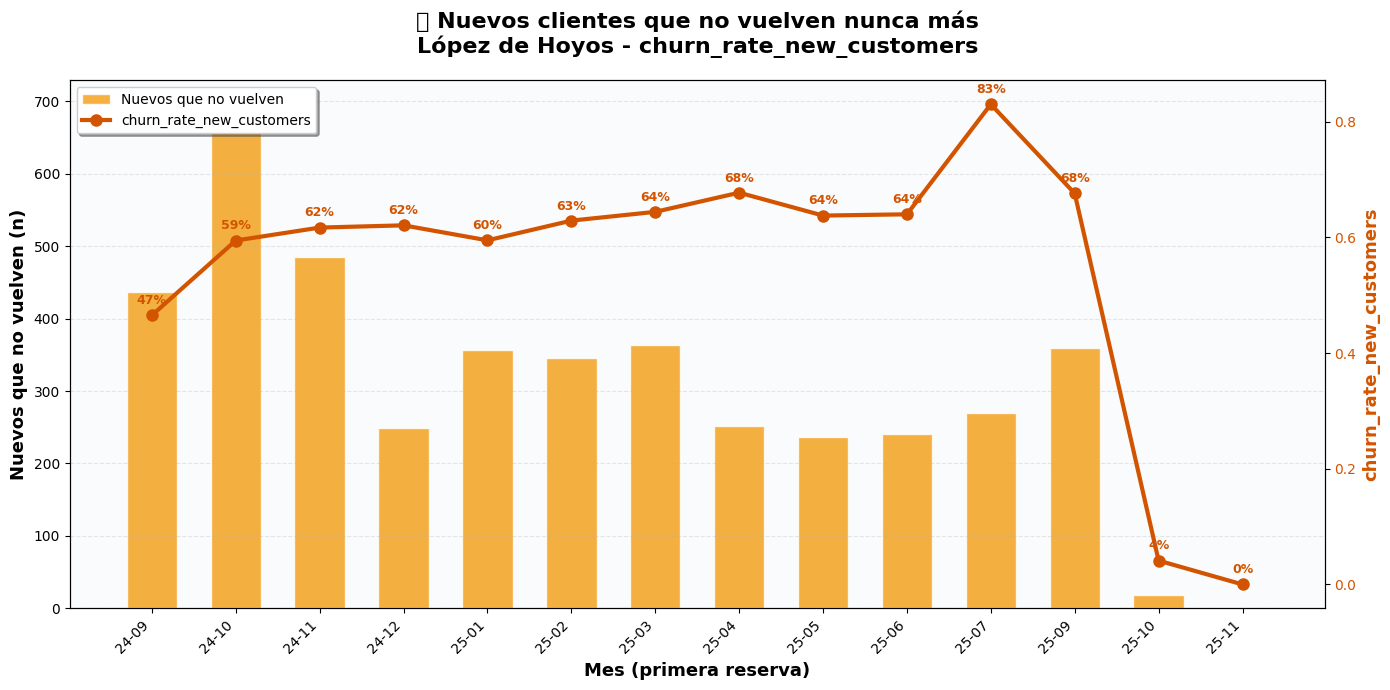


📉 churn_rate_old_customers (López de Hoyos):


,Mes,Clientes_Old_Activos,Churn_Old,churn_rate_old_customers
2024-10,2024-10,390,111,0.28
2024-11,2024-11,591,154,0.26
2024-12,2024-12,581,127,0.22
2025-01,2025-01,619,149,0.24
2025-02,2025-02,714,157,0.22
2025-03,2025-03,727,167,0.23
2025-04,2025-04,684,145,0.21
2025-05,2025-05,730,195,0.27
2025-06,2025-06,675,173,0.26
2025-07,2025-07,631,229,0.36


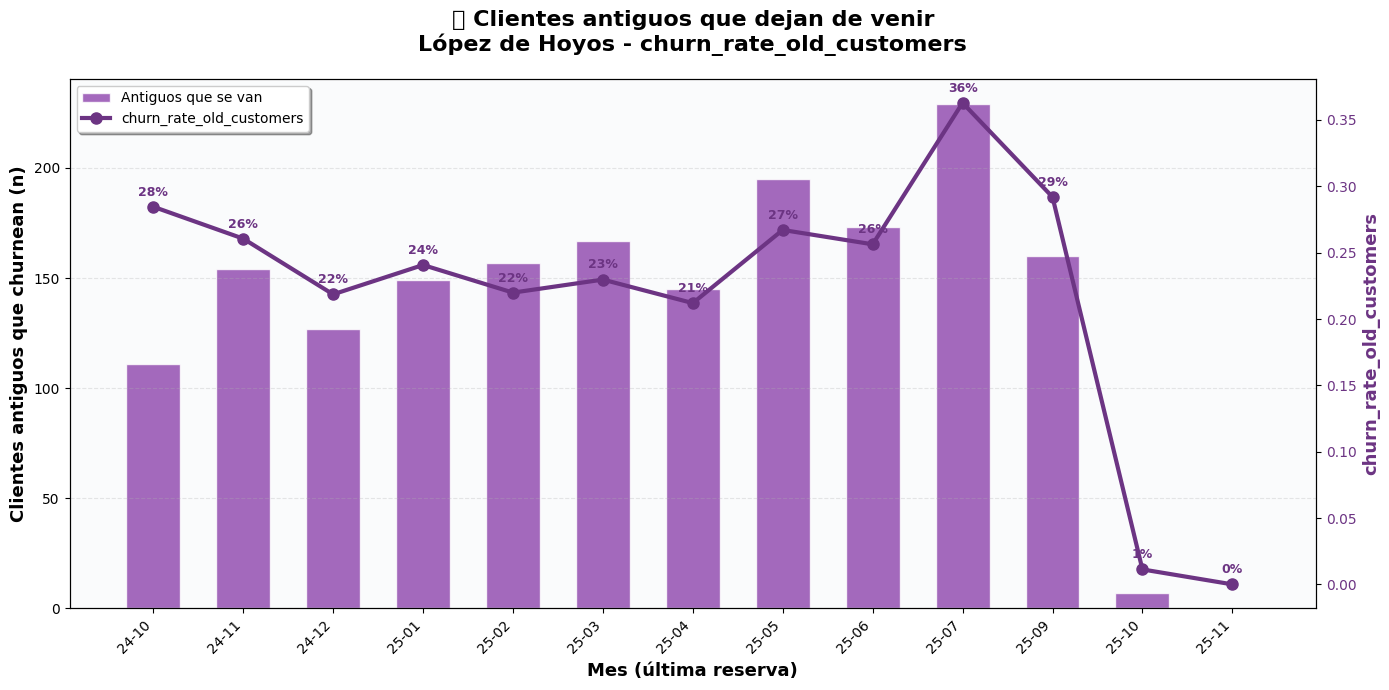


📊 Resumen combinado de churn en López de Hoyos:


,Nuevos_Clientes,Churn_New,churn_rate_new_customers,Clientes_Old_Activos,Churn_Old,churn_rate_old_customers
Mes,,,,,,
2024-09,937,436,0.47,NaN,NaN,NaN
2024-10,1167,694,0.59,390.00,111.00,0.28
2024-11,786,485,0.62,591.00,154.00,0.26
2024-12,401,249,0.62,581.00,127.00,0.22
2025-01,600,357,0.59,619.00,149.00,0.24
2025-02,550,346,0.63,714.00,157.00,0.22
2025-03,565,364,0.64,727.00,167.00,0.23
2025-04,372,252,0.68,684.00,145.00,0.21
2025-05,370,236,0.64,730.00,195.00,0.27


In [29]:
# 6.2 Churn en López de Hoyos: nuevos vs antiguos
pd.options.display.float_format = '{:.2f}'.format
import numpy as np

LOPEZ = 'López de Hoyos - esBarre'
UMBRAL_CHURN_DIAS = 60

print("="*70)
print("📉 Churn en López de Hoyos (nuevos vs antiguos)")
print("="*70)

# Fecha de corte: última fecha de visita del dataset
fecha_max = reservas['Fecha de Visita'].max().normalize()

# Volvemos a construir (o reutilizamos) la tabla de resumen por cliente
clientes_ordenados = reservas.sort_values('Fecha de Visita')

primera = (
    clientes_ordenados
    .groupby('ID del Cliente')
    .head(1)
    [['ID del Cliente', 'Fecha de Visita', 'Nombre de la Ubicacion']]
    .rename(columns={'Fecha de Visita': 'Primera_Reserva',
                     'Nombre de la Ubicacion': 'Ubicacion_Primera'})
)

ultima = (
    clientes_ordenados
    .groupby('ID del Cliente')
    .tail(1)
    [['ID del Cliente', 'Fecha de Visita', 'Nombre de la Ubicacion']]
    .rename(columns={'Fecha de Visita': 'Ultima_Reserva',
                     'Nombre de la Ubicacion': 'Ubicacion_Ultima'})
)

clientes_resumen = (
    primera
    .merge(ultima, on='ID del Cliente', how='left')
    .assign(
        Mes_Primera=lambda df_: df_['Primera_Reserva'].dt.to_period('M'),
        Mes_Ultima=lambda df_: df_['Ultima_Reserva'].dt.to_period('M')
    )
)

clientes_resumen['Dias_desde_ultima'] = (fecha_max - clientes_resumen['Ultima_Reserva']).dt.days

# -----------------------------------------------------------------------------
# 6.2.1 churn_rate_new_customers: % de nuevos que no vuelven nunca más
# -----------------------------------------------------------------------------

nuevos_lopez = clientes_resumen[clientes_resumen['Ubicacion_Primera'] == LOPEZ].copy()

nuevos_mes = (
    nuevos_lopez
    .groupby('Mes_Primera')['ID del Cliente']
    .nunique()
    .rename('Nuevos_Clientes')
)

churn_new_mes = (
    nuevos_lopez[
        (nuevos_lopez['Mes_Primera'] == nuevos_lopez['Mes_Ultima']) &
        (nuevos_lopez['Dias_desde_ultima'] >= UMBRAL_CHURN_DIAS)
    ]
    .groupby('Mes_Primera')['ID del Cliente']
    .nunique()
    .rename('Churn_New')
)

churn_new_df = (
    pd.concat([nuevos_mes, churn_new_mes], axis=1)
    .fillna(0)
    .astype({'Nuevos_Clientes': int, 'Churn_New': int})
)

churn_new_df['Mes'] = churn_new_df.index.astype(str)
churn_new_df['churn_rate_new_customers'] = np.where(
    churn_new_df['Nuevos_Clientes'] > 0,
    churn_new_df['Churn_New'] / churn_new_df['Nuevos_Clientes'],
    np.nan
)

churn_new_df = churn_new_df.sort_index()

print("\n📉 churn_rate_new_customers (López de Hoyos):")

display(churn_new_df[['Mes', 'Nuevos_Clientes', 'Churn_New', 'churn_rate_new_customers']])

fig, ax = plt.subplots(figsize=(14, 7))

meses_new = churn_new_df['Mes'].tolist()
x = np.arange(len(meses_new))

ax.bar(x, churn_new_df['Churn_New'], width=0.6, color='#f39c12', alpha=0.8,
       edgecolor='white', label='Nuevos que no vuelven')

ax2 = ax.twinx()
ax2.plot(x, churn_new_df['churn_rate_new_customers'], color='#d35400', linewidth=3,
         marker='o', markersize=8, label='churn_rate_new_customers')

for i, rate in enumerate(churn_new_df['churn_rate_new_customers']):
    if pd.isna(rate):
        continue
    ax2.annotate(f"{rate*100:.0f}%", (x[i], rate), textcoords='offset points',
                 xytext=(0, 8), ha='center', fontsize=9, fontweight='bold', color='#d35400')

ax.set_xlabel('Mes (primera reserva)', fontsize=13, fontweight='bold')
ax.set_ylabel('Nuevos que no vuelven (n)', fontsize=13, fontweight='bold')
ax2.set_ylabel('churn_rate_new_customers', fontsize=13, fontweight='bold', color='#d35400')
ax2.tick_params(axis='y', labelcolor='#d35400')

ax.set_title('📉 Nuevos clientes que no vuelven nunca más\nLópez de Hoyos - churn_rate_new_customers',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels([m[2:] for m in meses_new], rotation=45, ha='right')

lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left',
          frameon=True, fancybox=True, shadow=True)

ax.grid(True, axis='y', linestyle='--', alpha=0.3)
ax.set_facecolor('#fafbfc')
fig.patch.set_facecolor('white')

plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 6.2.2 churn_rate_old_customers: % de clientes antiguos que dejan de venir
# -----------------------------------------------------------------------------

# Base de clientes "antiguos" activos cada mes en López: reservas en López
# de clientes cuya primera reserva es anterior a ese mes.

reservas_lopez_ext = reservas_lopez.merge(
    clientes_resumen[['ID del Cliente', 'Mes_Primera']],
    on='ID del Cliente', how='left'
)

reservas_lopez_ext['Es_Nuevo_En_Mes'] = (
    reservas_lopez_ext['Año-Mes'] == reservas_lopez_ext['Mes_Primera']
)

base_old_mes = (
    reservas_lopez_ext[~reservas_lopez_ext['Es_Nuevo_En_Mes']]
    .groupby('Año-Mes')['ID del Cliente']
    .nunique()
    .rename('Clientes_Old_Activos')
)

# Clientes antiguos que churnean en López: última reserva en López,
# primera reserva en un mes anterior y al menos 60 días sin venir.

old_lopez_churn = clientes_resumen[
    (clientes_resumen['Ubicacion_Ultima'] == LOPEZ) &
    (clientes_resumen['Mes_Primera'] < clientes_resumen['Mes_Ultima']) &
    (clientes_resumen['Dias_desde_ultima'] >= UMBRAL_CHURN_DIAS)
].copy()

churn_old_mes = (
    old_lopez_churn
    .groupby('Mes_Ultima')['ID del Cliente']
    .nunique()
    .rename('Churn_Old')
)

churn_old_df = (
    pd.concat([base_old_mes, churn_old_mes], axis=1)
    .fillna(0)
)

churn_old_df['Clientes_Old_Activos'] = churn_old_df['Clientes_Old_Activos'].astype(int)
churn_old_df['Churn_Old'] = churn_old_df['Churn_Old'].astype(int)

churn_old_df['Mes'] = churn_old_df.index.astype(str)
churn_old_df['churn_rate_old_customers'] = np.where(
    churn_old_df['Clientes_Old_Activos'] > 0,
    churn_old_df['Churn_Old'] / churn_old_df['Clientes_Old_Activos'],
    np.nan
)

churn_old_df = churn_old_df.sort_index()

print("\n📉 churn_rate_old_customers (López de Hoyos):")

display(churn_old_df[['Mes', 'Clientes_Old_Activos', 'Churn_Old', 'churn_rate_old_customers']])

fig, ax = plt.subplots(figsize=(14, 7))

meses_old = churn_old_df['Mes'].tolist()
x = np.arange(len(meses_old))

ax.bar(x, churn_old_df['Churn_Old'], width=0.6, color='#8e44ad', alpha=0.8,
       edgecolor='white', label='Antiguos que se van')

ax2 = ax.twinx()
ax2.plot(x, churn_old_df['churn_rate_old_customers'], color='#6c3483', linewidth=3,
         marker='o', markersize=8, label='churn_rate_old_customers')

for i, rate in enumerate(churn_old_df['churn_rate_old_customers']):
    if pd.isna(rate):
        continue
    ax2.annotate(f"{rate*100:.0f}%", (x[i], rate), textcoords='offset points',
                 xytext=(0, 8), ha='center', fontsize=9, fontweight='bold', color='#6c3483')

ax.set_xlabel('Mes (última reserva)', fontsize=13, fontweight='bold')
ax.set_ylabel('Clientes antiguos que churnean (n)', fontsize=13, fontweight='bold')
ax2.set_ylabel('churn_rate_old_customers', fontsize=13, fontweight='bold', color='#6c3483')
ax2.tick_params(axis='y', labelcolor='#6c3483')

ax.set_title('📉 Clientes antiguos que dejan de venir\nLópez de Hoyos - churn_rate_old_customers',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels([m[2:] for m in meses_old], rotation=45, ha='right')

lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left',
          frameon=True, fancybox=True, shadow=True)

ax.grid(True, axis='y', linestyle='--', alpha=0.3)
ax.set_facecolor('#fafbfc')
fig.patch.set_facecolor('white')

plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 6.2.3 Tabla combinada para leerlo de un vistazo
# -----------------------------------------------------------------------------

churn_comb = (
    churn_new_df.set_index('Mes')[['Nuevos_Clientes', 'Churn_New', 'churn_rate_new_customers']]
    .join(
        churn_old_df.set_index('Mes')[['Clientes_Old_Activos', 'Churn_Old', 'churn_rate_old_customers']],
        how='outer'
    )
    .sort_index()
)

print("\n📊 Resumen combinado de churn en López de Hoyos:")

display(churn_comb)


📊 Reservas mensuales por cliente antiguo - López de Hoyos
Clientes totales en López de Hoyos: 7,825
Clientes 'antiguos' (≥2 meses activos): 2,711 (34.6% de la base de López)

📊 Estadísticas de reservas mensuales de clientes antiguos (López de Hoyos):


,count,mean,std,min,25%,50%,75%,max
Reservas_medias_por_mes,2711.0,2.479472,2.047384,1.0,1.0,1.75,3.0,23.5



📊 Distribución de clientes antiguos por reservas medias al mes:


,Clientes,% sobre clientes antiguos
Categoria_reservas_mes,,
0-1,0,0.0
1-2,1411,52.0
2-3,570,21.0
3-4,296,10.9
4+,397,14.6


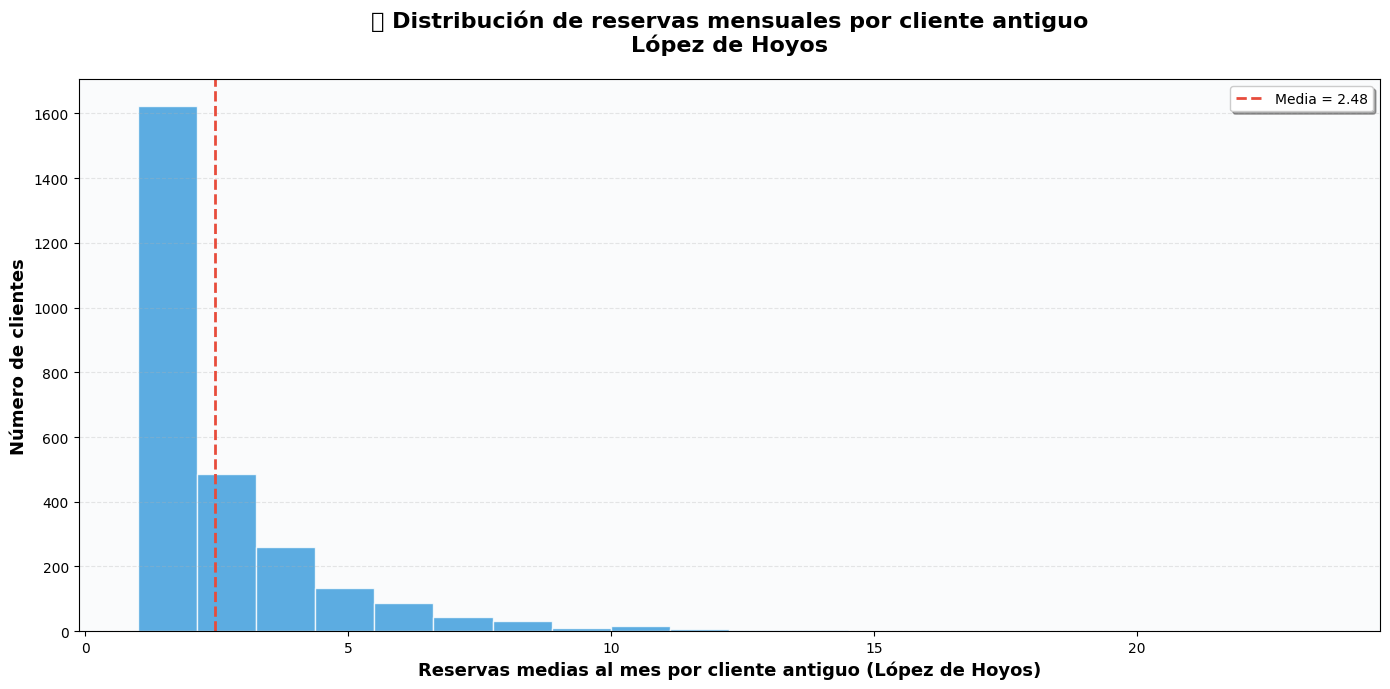

In [26]:
# 6.3 Reservas mensuales por cliente antiguo (López de Hoyos)

LOPEZ = 'López de Hoyos - esBarre'

print("="*70)
print("📊 Reservas mensuales por cliente antiguo - López de Hoyos")
print("="*70)

# Subconjunto solo López de Hoyos
reservas_lopez = reservas[reservas['Nombre de la Ubicacion'] == LOPEZ].copy()

# Mes de cada reserva
reservas_lopez['Mes_Periodo'] = reservas_lopez['Fecha de Visita'].dt.to_period('M')

# Reservas por cliente y mes (solo meses en los que vino al menos una vez)
cliente_mes = (
    reservas_lopez
    .groupby(['ID del Cliente', 'Mes_Periodo'])
    .size()
    .rename('Reservas_Mes')
    .reset_index()
)

# Resumen por cliente: meses activos y reservas totales
resumen_cliente = (
    cliente_mes
    .groupby('ID del Cliente')
    .agg(
        Meses_Activos=('Mes_Periodo', 'nunique'),
        Reservas_Totales=('Reservas_Mes', 'sum')
    )
)

# Media de reservas al mes por cliente (solo contando meses en los que vino)
resumen_cliente['Reservas_medias_por_mes'] = (
    resumen_cliente['Reservas_Totales'] / resumen_cliente['Meses_Activos']
)

# Definimos "clientes antiguos" como los que han estado activos al menos en 2 meses distintos
resumen_cliente['Es_Antiguo'] = resumen_cliente['Meses_Activos'] >= 2

antiguos = resumen_cliente[resumen_cliente['Es_Antiguo']].copy()

print(f"Clientes totales en López de Hoyos: {len(resumen_cliente):,}")
print(f"Clientes 'antiguos' (≥2 meses activos): {len(antiguos):,} "
      f"({len(antiguos) / len(resumen_cliente) * 100:.1f}% de la base de López)\n")

print("📊 Estadísticas de reservas mensuales de clientes antiguos (López de Hoyos):")

display(antiguos['Reservas_medias_por_mes'].describe().to_frame().T)

# Distribución por tramos de reservas mensuales
antiguos['Categoria_reservas_mes'] = pd.cut(
    antiguos['Reservas_medias_por_mes'],
    bins=[0, 1, 2, 3, 4, 10],
    labels=['0-1', '1-2', '2-3', '3-4', '4+'],
    include_lowest=True,
    right=False
)

dist = antiguos['Categoria_reservas_mes'].value_counts().sort_index()
dist_pct = (dist / len(antiguos) * 100).round(1)

tabla_dist = pd.concat([
    dist.rename('Clientes'),
    dist_pct.rename('% sobre clientes antiguos')
], axis=1)

print("\n📊 Distribución de clientes antiguos por reservas medias al mes:")

display(tabla_dist)

# Histograma de reservas medias al mes por cliente antiguo
fig, ax = plt.subplots(figsize=(14, 7))

ax.hist(
    antiguos['Reservas_medias_por_mes'],
    bins=20,
    color='#3498db',
    alpha=0.8,
    edgecolor='white'
)

media_global = antiguos['Reservas_medias_por_mes'].mean()
ax.axvline(media_global, color='#e74c3c', linestyle='--', linewidth=2,
           label=f'Media = {media_global:.2f}')

ax.set_xlabel('Reservas medias al mes por cliente antiguo (López de Hoyos)', fontsize=13, fontweight='bold')
ax.set_ylabel('Número de clientes', fontsize=13, fontweight='bold')
ax.set_title('📊 Distribución de reservas mensuales por cliente antiguo\nLópez de Hoyos',
             fontsize=16, fontweight='bold', pad=20)
ax.legend(frameon=True, fancybox=True, shadow=True)
ax.grid(True, axis='y', alpha=0.3, linestyle='--')
ax.set_facecolor('#fafbfc')
fig.patch.set_facecolor('white')

plt.tight_layout()
plt.show()


📈 Evolución histórica de la media de reservas por cliente antiguo - López de Hoyos
📊 Tabla de evolución histórica (cohorte = mes de primera reserva en López):


,Media_reservas_mes_por_cliente,Media_acumulada,Clientes_en_cohorte
Mes_Primera_Lopez,,,
2024-09,2.42,2.42,497
2024-10,2.28,2.35,467
2024-11,2.20,2.30,289
2024-12,2.29,2.30,150
2025-01,2.85,2.41,235
2025-02,2.23,2.38,198
2025-03,2.34,2.37,196
2025-04,2.34,2.37,114
2025-05,2.79,2.42,129


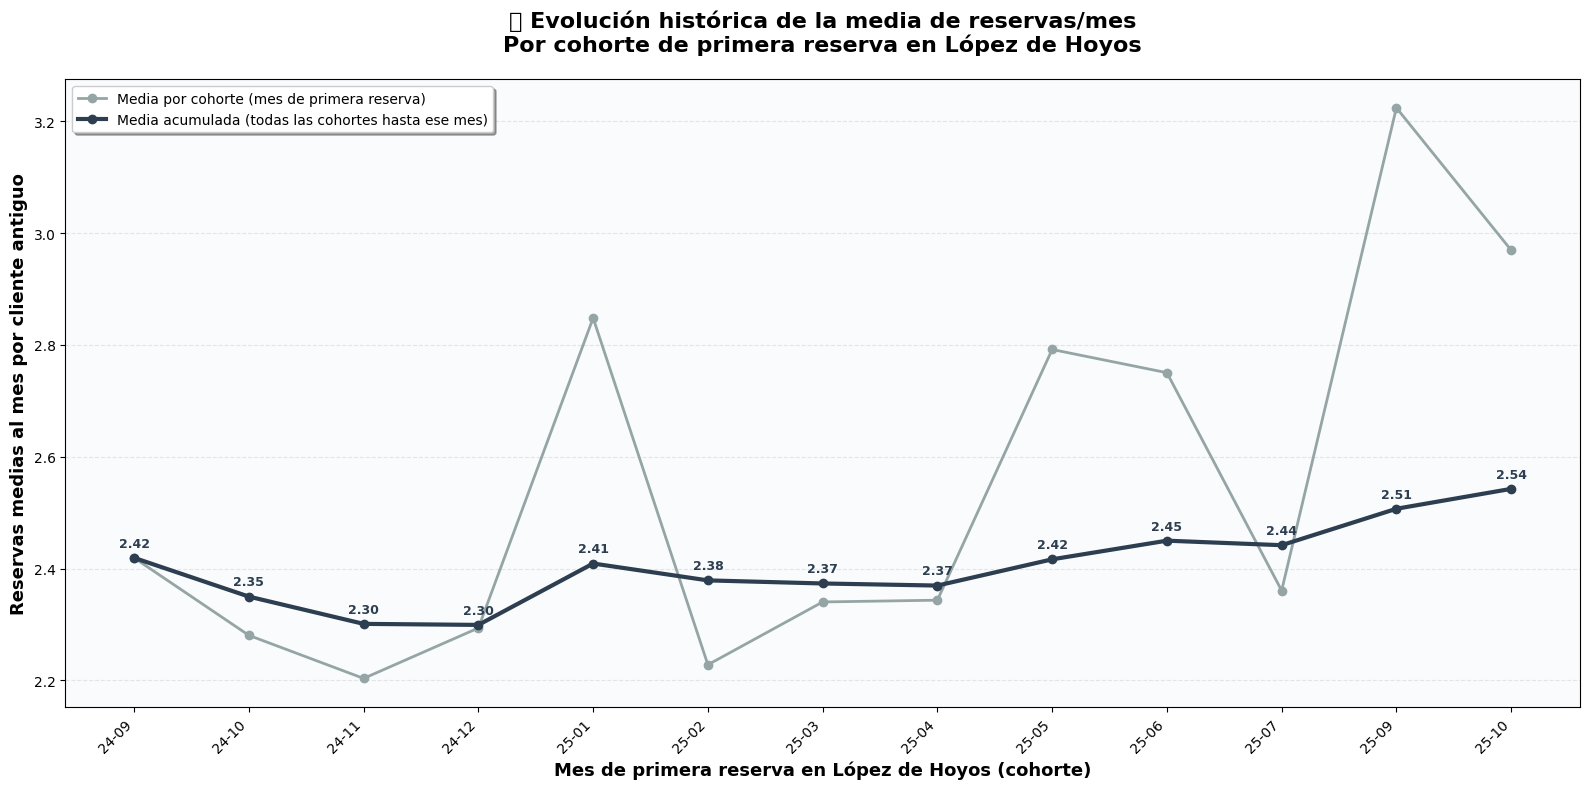

In [32]:
# 6.4 Evolución histórica de la media de reservas por cliente antiguo (López de Hoyos)

LOPEZ = 'López de Hoyos - esBarre'

print("="*70)
print("📈 Evolución histórica de la media de reservas por cliente antiguo - López de Hoyos")
print("="*70)

# -----------------------------------------------------------------------------
# 1) Reconstruimos la tabla cliente-mes para López de Hoyos
# -----------------------------------------------------------------------------

reservas_lopez = reservas[reservas['Nombre de la Ubicacion'] == LOPEZ].copy()
reservas_lopez['Mes_Periodo'] = reservas_lopez['Fecha de Visita'].dt.to_period('M')

cliente_mes = (
    reservas_lopez
    .groupby(['ID del Cliente', 'Mes_Periodo'])
    .size()
    .rename('Reservas_Mes')
    .reset_index()
)

# Resumen por cliente: meses activos y reservas totales en López
resumen_cliente = (
    cliente_mes
    .groupby('ID del Cliente')
    .agg(
        Meses_Activos=('Mes_Periodo', 'nunique'),
        Reservas_Totales=('Reservas_Mes', 'sum')
    )
    .reset_index()  # Dejamos 'ID del Cliente' como columna para poder agrupar después
)

resumen_cliente['Reservas_medias_por_mes'] = (
    resumen_cliente['Reservas_Totales'] / resumen_cliente['Meses_Activos']
)

# Nos quedamos solo con clientes "antiguos" (≥2 meses activos)
resumen_cliente = resumen_cliente[resumen_cliente['Meses_Activos'] >= 2].copy()

# Mes de primera reserva en López para cada cliente
mes_primera_lopez = (
    cliente_mes
    .groupby('ID del Cliente')['Mes_Periodo']
    .min()
    .rename('Mes_Primera_Lopez')
)

resumen_cliente = resumen_cliente.merge(mes_primera_lopez, on='ID del Cliente', how='left')

# -----------------------------------------------------------------------------
# 2) Serie histórica: para cada mes de primera reserva, media de reservas/mes
# -----------------------------------------------------------------------------

serie_media_cohorte = (
    resumen_cliente
    .groupby('Mes_Primera_Lopez')['Reservas_medias_por_mes']
    .mean()
    .sort_index()
    .rename('Media_reservas_mes_por_cliente')
)

# Nº de clientes en cada cohorte (para contexto)
clientes_cohorte = (
    resumen_cliente
    .groupby('Mes_Primera_Lopez')['ID del Cliente']
    .nunique()
    .rename('Clientes_en_cohorte')
)

# Media acumulada sobre la serie histórica (desde la primera cohorte hasta cada mes)
media_acumulada_cohorte = (
    serie_media_cohorte
    .expanding()
    .mean()
    .rename('Media_acumulada')
)

hist_media = pd.concat([
    serie_media_cohorte,
    media_acumulada_cohorte,
    clientes_cohorte
], axis=1)

hist_media.index = hist_media.index.astype(str)

print("📊 Tabla de evolución histórica (cohorte = mes de primera reserva en López):")

display(hist_media)

# -----------------------------------------------------------------------------
# 3) Gráfico: media por cohorte vs media acumulada
# -----------------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(16, 8))

meses_hist = hist_media.index.tolist()

ax.plot(
    meses_hist,
    hist_media['Media_reservas_mes_por_cliente'].values,
    marker='o', linewidth=2, color='#95a5a6', label='Media por cohorte (mes de primera reserva)'
)

ax.plot(
    meses_hist,
    hist_media['Media_acumulada'].values,
    marker='o', linewidth=3, color='#2c3e50', label='Media acumulada (todas las cohortes hasta ese mes)'
)

# Etiquetas sobre la línea acumulada para facilitar la lectura
for x_tick, val in zip(meses_hist, hist_media['Media_acumulada'].values):
    ax.annotate(
        f"{val:.2f}",
        (x_tick, val),
        textcoords='offset points',
        xytext=(0, 8),
        ha='center',
        fontsize=9,
        fontweight='bold',
        color='#2c3e50'
    )

ax.set_xlabel('Mes de primera reserva en López de Hoyos (cohorte)', fontsize=13, fontweight='bold')
ax.set_ylabel('Reservas medias al mes por cliente antiguo', fontsize=13, fontweight='bold')
ax.set_title('📈 Evolución histórica de la media de reservas/mes\nPor cohorte de primera reserva en López de Hoyos',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(meses_hist)
ax.set_xticklabels([m[2:] for m in meses_hist], rotation=45, ha='right')
ax.legend(loc='upper left', frameon=True, fancybox=True, shadow=True)
ax.grid(True, axis='y', linestyle='--', alpha=0.3)
ax.set_facecolor('#fafbfc')
fig.patch.set_facecolor('white')

plt.tight_layout()
plt.show()


📊 Nuevos clientes y churn por tipo_reserva - López de Hoyos

📈 Nuevos clientes por mes y tipo_reserva (primera reserva en López de Hoyos):


Tipo_Primera,Bonos,Clase Suelta,ClassPass,Descuentos,Gympass
Mes,,,,,
2024-09,63,128,463,107,176
2024-10,64,147,741,7,208
2024-11,29,123,503,1,130
2024-12,19,69,240,1,72
2025-01,39,123,298,8,132
2025-02,26,83,335,2,104
2025-03,23,111,318,1,112
2025-04,16,87,193,2,74
2025-05,12,64,199,2,93


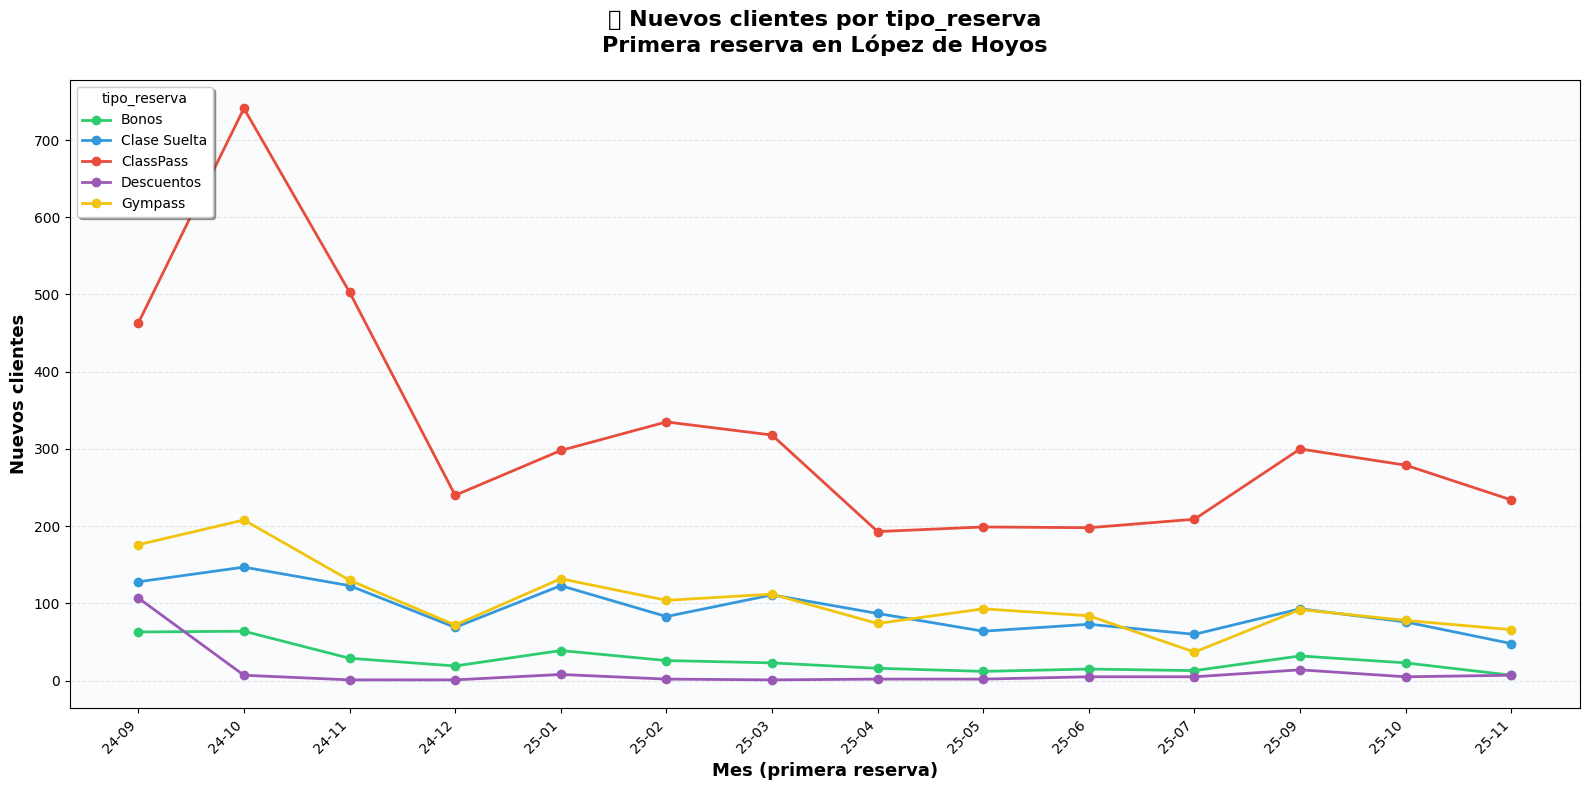


📉 churn_rate_new_customers por mes y tipo_reserva (López de Hoyos):


Tipo_Primera,Bonos,Clase Suelta,ClassPass,Descuentos,Gympass
Mes,,,,,
2024-09,0.03,0.62,0.54,0.58,0.24
2024-10,0.33,0.66,0.67,0.86,0.36
2024-11,0.10,0.65,0.70,0.00,0.38
2024-12,0.26,0.68,0.69,1.00,0.42
2025-01,0.13,0.54,0.78,0.50,0.37
2025-02,0.15,0.66,0.75,0.00,0.34
2025-03,0.22,0.69,0.73,0.00,0.44
2025-04,0.50,0.74,0.76,0.50,0.43
2025-05,0.17,0.67,0.77,1.00,0.39


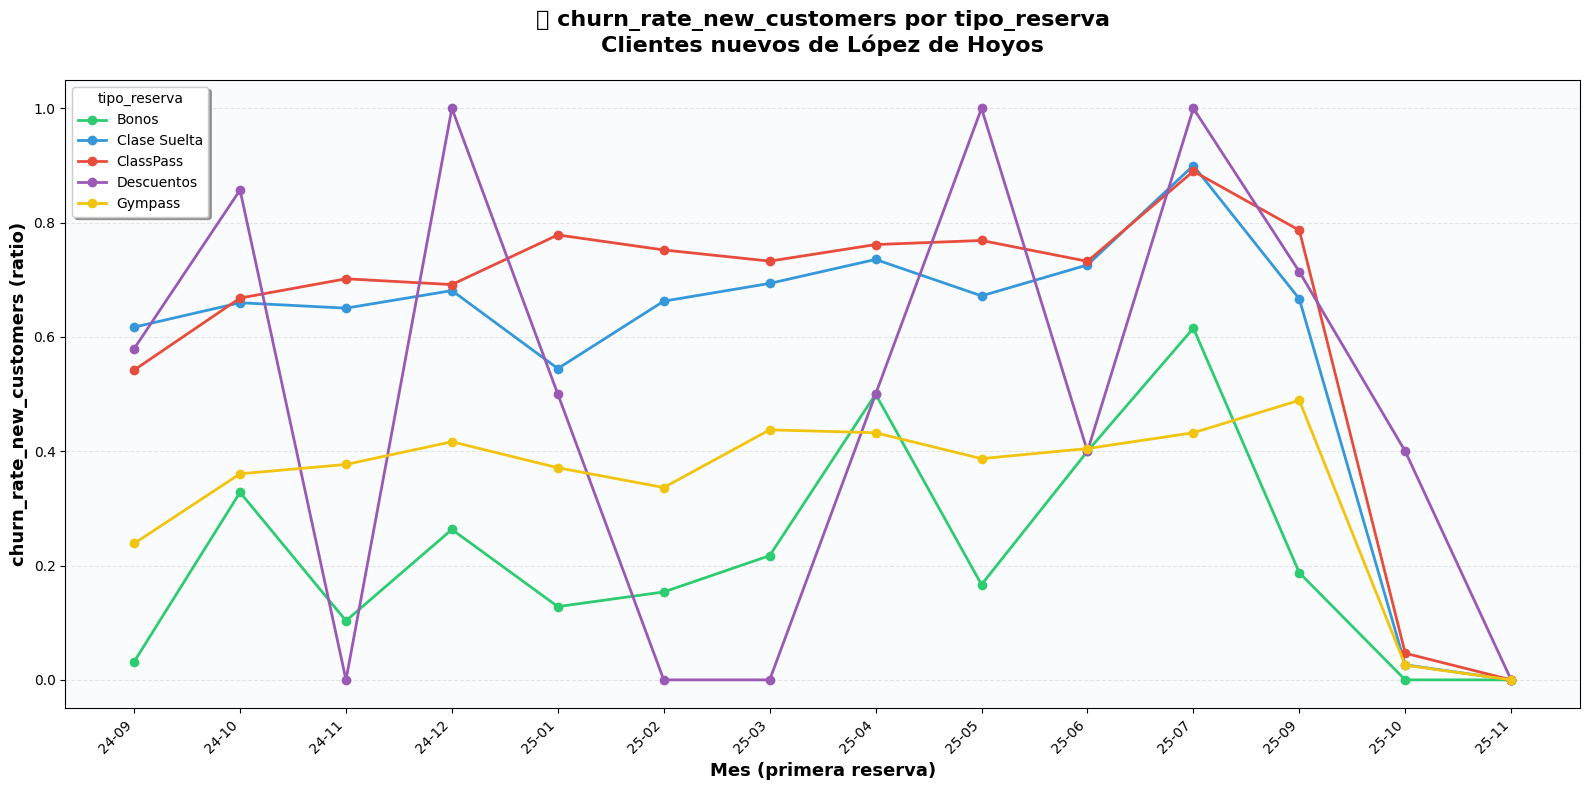


📉 churn_rate_old_customers por mes y tipo_reserva (López de Hoyos):


tipo_reserva,Bonos,Clase Suelta,ClassPass,Descuentos,Gympass
Mes,,,,,
2024-10,0.40,0.50,0.28,0.40,0.14
2024-11,0.18,0.27,0.37,0.50,0.17
2024-12,0.19,0.29,0.33,0.00,0.11
2025-01,0.10,0.32,0.38,NaN,0.17
2025-02,0.17,0.25,0.34,0.00,0.13
2025-03,0.12,0.24,0.40,NaN,0.18
2025-04,0.15,0.21,0.31,0.00,0.18
2025-05,0.14,0.61,0.42,NaN,0.20
2025-06,0.15,0.40,0.37,0.00,0.23


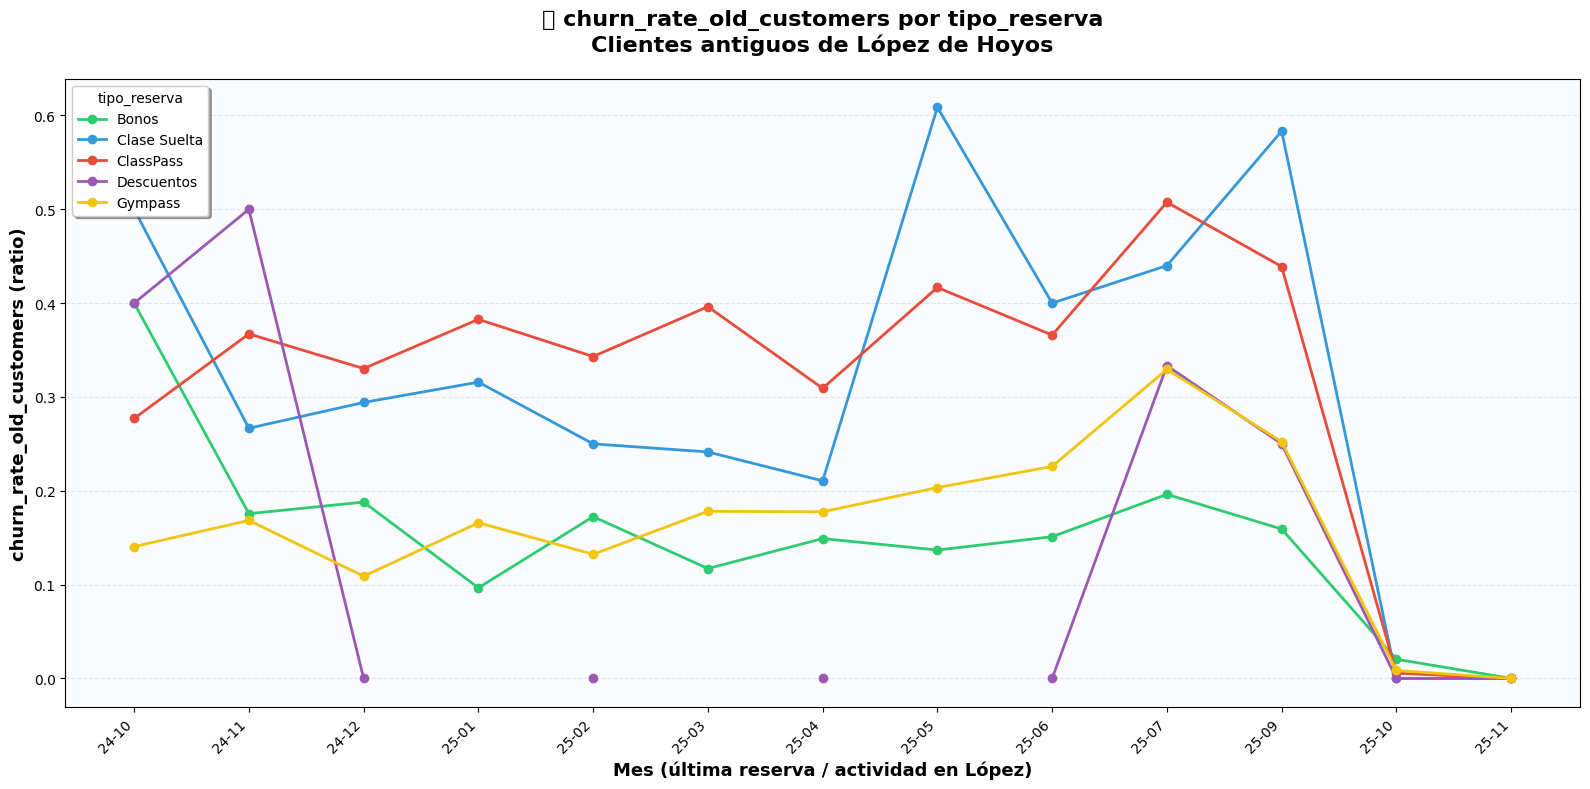

In [37]:
# 6.5 Nuevos clientes y churn (nuevos y antiguos) por tipo_reserva en López de Hoyos

LOPEZ = 'López de Hoyos - esBarre'
UMBRAL_CHURN_DIAS = 60

print("="*70)
print("📊 Nuevos clientes y churn por tipo_reserva - López de Hoyos")
print("="*70)

# -----------------------------------------------------------------------------
# 1) Tabla de detalle de clientes: primera y última reserva (con tipo_reserva)
# -----------------------------------------------------------------------------

reservas_ordenadas = reservas.sort_values('Fecha de Visita')

primera_det = (
    reservas_ordenadas
    .groupby('ID del Cliente')
    .head(1)
    [['ID del Cliente', 'Fecha de Visita', 'Nombre de la Ubicacion', 'tipo_reserva']]
    .rename(columns={
        'Fecha de Visita': 'Primera_Reserva',
        'Nombre de la Ubicacion': 'Ubicacion_Primera',
        'tipo_reserva': 'Tipo_Primera'
    })
)

ultima_det = (
    reservas_ordenadas
    .groupby('ID del Cliente')
    .tail(1)
    [['ID del Cliente', 'Fecha de Visita', 'Nombre de la Ubicacion', 'tipo_reserva']]
    .rename(columns={
        'Fecha de Visita': 'Ultima_Reserva',
        'Nombre de la Ubicacion': 'Ubicacion_Ultima',
        'tipo_reserva': 'Tipo_Ultima'
    })
)

clientes_detalle = (
    primera_det
    .merge(ultima_det, on='ID del Cliente', how='left')
)

clientes_detalle['Mes_Primera'] = clientes_detalle['Primera_Reserva'].dt.to_period('M')
clientes_detalle['Mes_Ultima'] = clientes_detalle['Ultima_Reserva'].dt.to_period('M')

fecha_max = reservas['Fecha de Visita'].max().normalize()
clientes_detalle['Dias_desde_ultima'] = (fecha_max - clientes_detalle['Ultima_Reserva']).dt.days

# -----------------------------------------------------------------------------
# 2) Nuevos clientes por tipo_reserva (primera reserva en López de Hoyos)
# -----------------------------------------------------------------------------

nuevos_lopez = clientes_detalle[clientes_detalle['Ubicacion_Primera'] == LOPEZ].copy()

nuevos_mes_tipo = (
    nuevos_lopez
    .groupby(['Mes_Primera', 'Tipo_Primera'])['ID del Cliente']
    .nunique()
    .reset_index(name='Nuevos_Clientes')
    .sort_values(['Mes_Primera', 'Tipo_Primera'])
)

nuevos_mes_tipo['Mes'] = nuevos_mes_tipo['Mes_Primera'].astype(str)

print("\n📈 Nuevos clientes por mes y tipo_reserva (primera reserva en López de Hoyos):")

pivot_nuevos = (
    nuevos_mes_tipo
    .pivot(index='Mes', columns='Tipo_Primera', values='Nuevos_Clientes')
    .fillna(0)
    .astype(int)
)

display(pivot_nuevos)

fig, ax = plt.subplots(figsize=(16, 8))

meses = pivot_nuevos.index.tolist()
colores = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6', '#f1c40f', '#1abc9c', '#e67e22']

for i, tipo in enumerate(pivot_nuevos.columns):
    ax.plot(
        meses,
        pivot_nuevos[tipo].values,
        marker='o',
        linewidth=2,
        color=colores[i % len(colores)],
        label=str(tipo)
    )

ax.set_xlabel('Mes (primera reserva)', fontsize=13, fontweight='bold')
ax.set_ylabel('Nuevos clientes', fontsize=13, fontweight='bold')
ax.set_title('📈 Nuevos clientes por tipo_reserva\nPrimera reserva en López de Hoyos',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(meses)
ax.set_xticklabels([m[2:] for m in meses], rotation=45, ha='right')
ax.legend(loc='upper left', frameon=True, fancybox=True, shadow=True, title='tipo_reserva')
ax.grid(True, axis='y', linestyle='--', alpha=0.3)
ax.set_facecolor('#fafbfc')
fig.patch.set_facecolor('white')

plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 3) churn_rate_new_customers por tipo_reserva
#    (nuevos de López que nunca vuelven, por tipo de su primera reserva)
# -----------------------------------------------------------------------------

churn_new_lopez = nuevos_lopez[
    (nuevos_lopez['Mes_Primera'] == nuevos_lopez['Mes_Ultima']) &
    (nuevos_lopez['Dias_desde_ultima'] >= UMBRAL_CHURN_DIAS)
].copy()

churn_new_mes_tipo = (
    churn_new_lopez
    .groupby(['Mes_Primera', 'Tipo_Primera'])['ID del Cliente']
    .nunique()
    .reset_index(name='Churn_New')
)

churn_new_join = (
    nuevos_mes_tipo
    .merge(churn_new_mes_tipo,
           on=['Mes_Primera', 'Tipo_Primera'],
           how='left')
    .fillna({'Churn_New': 0})
)

churn_new_join['Churn_New'] = churn_new_join['Churn_New'].astype(int)
churn_new_join['churn_rate_new_customers_tipo'] = (
    churn_new_join['Churn_New'] / churn_new_join['Nuevos_Clientes']
)

churn_new_join['Mes'] = churn_new_join['Mes_Primera'].astype(str)

print("\n📉 churn_rate_new_customers por mes y tipo_reserva (López de Hoyos):")

pivot_churn_new = (
    churn_new_join
    .pivot(index='Mes', columns='Tipo_Primera', values='churn_rate_new_customers_tipo')
    .sort_index()
)

display(pivot_churn_new)

fig, ax = plt.subplots(figsize=(16, 8))

meses = pivot_churn_new.index.tolist()

for i, tipo in enumerate(pivot_churn_new.columns):
    ax.plot(
        meses,
        pivot_churn_new[tipo].values,
        marker='o',
        linewidth=2,
        color=colores[i % len(colores)],
        label=str(tipo)
    )

ax.set_xlabel('Mes (primera reserva)', fontsize=13, fontweight='bold')
ax.set_ylabel('churn_rate_new_customers (ratio)', fontsize=13, fontweight='bold')
ax.set_title('📉 churn_rate_new_customers por tipo_reserva\nClientes nuevos de López de Hoyos',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(meses)
ax.set_xticklabels([m[2:] for m in meses], rotation=45, ha='right')
ax.legend(loc='upper left', frameon=True, fancybox=True, shadow=True, title='tipo_reserva')
ax.grid(True, axis='y', linestyle='--', alpha=0.3)
ax.set_facecolor('#fafbfc')
fig.patch.set_facecolor('white')

plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 4) churn_rate_old_customers por tipo_reserva
#    (clientes antiguos que dejan de venir, por tipo de su última reserva en esBarre)
# -----------------------------------------------------------------------------

# Subconjunto de reservas de López de Hoyos con info de mes
reservas_lopez = reservas[reservas['Nombre de la Ubicacion'] == LOPEZ].copy()
reservas_lopez['Mes_Periodo'] = reservas_lopez['Fecha de Visita'].dt.to_period('M')

# Añadimos Mes_Primera global a cada reserva para saber si es nuevo ese mes o no
reservas_lopez_ext = reservas_lopez.merge(
    clientes_detalle[['ID del Cliente', 'Mes_Primera']],
    on='ID del Cliente', how='left'
)

reservas_lopez_ext['Es_Nuevo_En_Mes'] = (
    reservas_lopez_ext['Mes_Periodo'] == reservas_lopez_ext['Mes_Primera']
)

# Base de clientes "old" activos por mes y tipo_reserva en López:
# reservas en López de clientes cuya primera reserva global es anterior a ese mes
base_old_mes_tipo = (
    reservas_lopez_ext[~reservas_lopez_ext['Es_Nuevo_En_Mes']]
    .groupby(['Mes_Periodo', 'tipo_reserva'])['ID del Cliente']
    .nunique()
    .reset_index(name='Clientes_Old_Activos')
)

# Clientes antiguos que churnean y cuya última reserva (en esBarre) es en López
old_lopez_churn = clientes_detalle[
    (clientes_detalle['Ubicacion_Ultima'] == LOPEZ) &
    (clientes_detalle['Mes_Primera'] < clientes_detalle['Mes_Ultima']) &
    (clientes_detalle['Dias_desde_ultima'] >= UMBRAL_CHURN_DIAS)
].copy()

churn_old_mes_tipo = (
    old_lopez_churn
    .groupby(['Mes_Ultima', 'Tipo_Ultima'])['ID del Cliente']
    .nunique()
    .reset_index(name='Churn_Old')
)

# Combinamos base y churn por mes y tipo
churn_old_join = base_old_mes_tipo.merge(
    churn_old_mes_tipo,
    left_on=['Mes_Periodo', 'tipo_reserva'],
    right_on=['Mes_Ultima', 'Tipo_Ultima'],
    how='left'
)

churn_old_join['Churn_Old'] = churn_old_join['Churn_Old'].fillna(0).astype(int)
churn_old_join['churn_rate_old_customers_tipo'] = (
    churn_old_join['Churn_Old'] / churn_old_join['Clientes_Old_Activos']
)

churn_old_join['Mes'] = churn_old_join['Mes_Periodo'].astype(str)

print("\n📉 churn_rate_old_customers por mes y tipo_reserva (López de Hoyos):")

pivot_churn_old = (
    churn_old_join
    .pivot(index='Mes', columns='tipo_reserva', values='churn_rate_old_customers_tipo')
    .sort_index()
)

display(pivot_churn_old)

fig, ax = plt.subplots(figsize=(16, 8))

meses = pivot_churn_old.index.tolist()

for i, tipo in enumerate(pivot_churn_old.columns):
    ax.plot(
        meses,
        pivot_churn_old[tipo].values,
        marker='o',
        linewidth=2,
        color=colores[i % len(colores)],
        label=str(tipo)
    )

ax.set_xlabel('Mes (última reserva / actividad en López)', fontsize=13, fontweight='bold')
ax.set_ylabel('churn_rate_old_customers (ratio)', fontsize=13, fontweight='bold')
ax.set_title('📉 churn_rate_old_customers por tipo_reserva\nClientes antiguos de López de Hoyos',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(meses)
ax.set_xticklabels([m[2:] for m in meses], rotation=45, ha='right')
ax.legend(loc='upper left', frameon=True, fancybox=True, shadow=True, title='tipo_reserva')
ax.grid(True, axis='y', linestyle='--', alpha=0.3)
ax.set_facecolor('#fafbfc')
fig.patch.set_facecolor('white')

plt.tight_layout()
plt.show()


In [38]:
# 6.6 Medias de churn rate por tipo_reserva (nuevos vs antiguos) - López de Hoyos

print("="*70)
print("📊 Medias de churn rate por tipo_reserva (nuevos vs antiguos) - López de Hoyos")
print("="*70)

# -----------------------------------------------------------------------------
# 1) Medias para churn de nuevos (churn_new_join de la celda 6.5)
# -----------------------------------------------------------------------------

media_churn_new_tipo = (
    churn_new_join
    .groupby('Tipo_Primera')
    .agg(
        churn_rate_new_media_simple=('churn_rate_new_customers_tipo', 'mean'),
        Nuevos_Clientes_Totales=('Nuevos_Clientes', 'sum'),
        Churn_New_Totales=('Churn_New', 'sum')
    )
)

media_churn_new_tipo['churn_rate_new_media_ponderada'] = (
    media_churn_new_tipo['Churn_New_Totales'] / media_churn_new_tipo['Nuevos_Clientes_Totales']
)

# -----------------------------------------------------------------------------
# 2) Medias para churn de antiguos (churn_old_join de la celda 6.5)
# -----------------------------------------------------------------------------

media_churn_old_tipo = (
    churn_old_join
    .groupby('tipo_reserva')
    .agg(
        churn_rate_old_media_simple=('churn_rate_old_customers_tipo', 'mean'),
        Clientes_Old_Activos_Totales=('Clientes_Old_Activos', 'sum'),
        Churn_Old_Totales=('Churn_Old', 'sum')
    )
)

media_churn_old_tipo['churn_rate_old_media_ponderada'] = (
    media_churn_old_tipo['Churn_Old_Totales'] / media_churn_old_tipo['Clientes_Old_Activos_Totales']
)

# -----------------------------------------------------------------------------
# 3) Tabla combinada por tipo_reserva
# -----------------------------------------------------------------------------

resumen_churn_tipo = (
    media_churn_new_tipo
    .rename_axis('tipo_reserva')
    .reset_index()
    .merge(
        media_churn_old_tipo.reset_index(),
        on='tipo_reserva',
        how='outer'
    )
)

# Ordenar por churn_old ponderado descendente (dónde se nos van más antiguos)
resumen_churn_tipo = resumen_churn_tipo.sort_values(
    by='churn_rate_old_media_ponderada', ascending=False
)

print("\n📊 Resumen de medias de churn por tipo_reserva (López de Hoyos):\n")

display(resumen_churn_tipo)



📊 Medias de churn rate por tipo_reserva (nuevos vs antiguos) - López de Hoyos

📊 Resumen de medias de churn por tipo_reserva (López de Hoyos):



,tipo_reserva,churn_rate_new_media_simple,Nuevos_Clientes_Totales,Churn_New_Totales,churn_rate_new_media_ponderada,churn_rate_old_media_simple,Clientes_Old_Activos_Totales,Churn_Old_Totales,churn_rate_old_media_ponderada
1,Clase Suelta,0.59,1285,780,0.61,0.32,242,81,0.33
2,ClassPass,0.63,4510,2862,0.63,0.32,2667,870,0.33
3,Descuentos,0.50,167,95,0.57,0.15,25,6,0.24
4,Gympass,0.34,1458,494,0.34,0.16,3035,501,0.17
0,Bonos,0.22,381,75,0.20,0.15,2237,316,0.14
